* Course: YSC4103 MCS Capstone
* Date created: 2019/02/25
* Name: Linfan XIAO
* Description: Implement the Fokas method as described in "Evolution PDEs and augmented eigenfunctions. Finite interval."

Let $C=C^{\infty}[0,1]$ be the set of functions with derivatives of all orders on $[0,1]$. 

Define $n$ linearly independent boundary forms $\{B_j: C\to\mathbb{C}\mid j\in\{1,2,\ldots,n\}\}$ as follows:
\begin{align*}
B_j\phi &= \sum_{k=0}^{n-1} \left(b_{jk}\phi^{(k)}(0) + \beta_{jk}\phi^{(k)}(1)\right),\quad j\in \{1,2,\ldots, n\},
\end{align*}
where $b_{jk}, \beta_{jk}\in\mathbb{R}$ are boundary coefficients. Define 
\begin{align*}
\Phi &= \{\phi\in C: B_j\phi = 0\,\forall j \in \{1,2,\ldots, n\}\}
\end{align*}
to be the set of $n$ homogeneous boundary conditions
\begin{align*}
\left(b_{11}\phi^{(0)}(0) + \beta_{11}\phi^{(0)}(1)\right) + \cdots +\left(b_{1n}\phi^{(n-1)}(0) + \beta_{1n}\phi^{(n-1)}(1)\right) &= 0\\
&\vdots\\
\left(b_{n1}\phi^{(0)}(0) + \beta_{n1}\phi^{(0)}(1)\right) + \cdots +\left(b_{nn}\phi^{(n-1)}(0) + \beta_{nn}\phi^{(n-1)}(1)\right) &= 0.
\end{align*}
Let $S:\Phi\to C$ be the linear differential operator 
$$S\phi(x) = (-i)^n \phi^{(n)}(x).$$

Let $a\in\mathbb{C}$ be a constant. Consider the homogeneous initial-boundary value problem (IBVP):
\begin{alignat*}{2}
(\partial_t + aS)q(x,t) &= 0,\quad&(x,t)\in (0,1)\times (0,T)\\
q(x,0)&\in\Phi,\quad &x\in [0,1]\\
q(\cdot, t) &\in\Phi,\quad &t\in [0,T]
\end{alignat*}
Let $f(x):=q(x,0)$. We reqire that if $n$ is odd then $a=\pm i$ and if $n$ is even then $\Re(a)\geq 0$. We solve the IBVP for $q(x,t)$.

# Importing packages

In [1]:
using SymPy
using PyCall
sympy = pyimport("sympy")
# using Roots
using Distributions
# using IntervalArithmetic
# using IntervalRootFinding
using ApproxFun

using Plots

using NBInclude
using QuadGK
import QuadGK.quadgk
# using HCubature
using ApproxFun
using Roots
using Gadfly
using PyPlot
# pygui(true)

# Global variables

## `TOL`

Error tolerance level.

In [2]:
TOL = 1e-05

1.0e-5

## `DIGITS`

The number of digits to display in symbolic expressions.

In [3]:
DIGITS = 3

3

## `INFTY`

A number representing infinity in numerical approximations.

In [4]:
INFTY = 10

10

## `t`

Free symbol in the unknown function $x(t)$ in the differential equation $Lx=0$.

In [5]:
# t = symbols("t")

## `sympyExpr`s

Sample expressions of type addition, multiplication, power, and exponential in `SymPy`.

In [6]:
x = symbols("x")
sympyAddExpr = 1 + x

x + 1

In [7]:
sympyMultExpr = 2*x

2*x

In [8]:
sympyPowerExpr = x^2

 2
x 

In [9]:
sympyExpExpr = e^x

 x
e 

# Helper functions

## `check_all(array, condition)`

Checks whether all elements in an array satisfy a given condition.

In [10]:
function check_all(array, condition)
    for x in array
        if !condition(x)
            return false
        end
    end
    return true
end

check_all (generic function with 1 method)

## `check_any(array, condition)`

Checks whether any element in an array satisfy a given condition.

In [11]:
function check_any(array, condition)
    for x in array
        if condition(x)
            return true
        end
    end
    return false
end

check_any (generic function with 1 method)

## `set_tol(x, y)`

Sets an appropriate tolerance for checking whether two numbers or two arrays of numbers are approximately equal.

In [12]:
function set_tol(x::Union{Number, Array}, y::Union{Number, Array}; atol = TOL)
    if isa(x, Number) && isa(y, Number)
       return atol * mean([x y])
    elseif isa(x, Array) && isa(y, Array)
        if size(x) != size(y)
            throw(error("Array dimensions do not match"))
        end
        # Avoid InexactError() when taking norm()
        x = convert(Array{Complex}, x)
        y = convert(Array{Complex}, y)
        return atol * (norm(x,2) + norm(y,2))
    else
        throw(error("Invalid input"))
    end
end

set_tol (generic function with 1 method)

## `evaluate(func, a)`

Evaluate a univariate function or an array of them at a given value.

In [13]:
function evaluate(func::Union{Function,Number}, a::Number)
    if isa(func, Function)
        funcA = func(a)
    elseif isa(func, SymPy.Sym) # SymPy.Sym must come before Number because SymPy.Sym will be recognized as Number
        freeSymbols = free_symbols(func)
        if length(freeSymbols) > 1
            throw(error("func should be univariate"))
        elseif length(freeSymbols) == 1
            t = free_symbols(func)[1,1]
            if isa(a, SymPy.Sym) # if x is SymPy.Sym, do not convert result to Number to preserve pretty printing
                funcA = subs(func, t, a)
            else
                funcA = SymPy.N(subs(func, t, a))
            end
        else
            funcA = func
        end
    else # func is Number
        funcA = func
    end
    return funcA
end

evaluate (generic function with 1 method)

## `partition(n)`

Generate ordered two-integer partitions ($0$ included) of a given non-negative integer.

In [14]:
function partition(n::Int)
    if n < 0
        throw(error("Non-negative n required"))
    end
    output = []
    for i = 0:n
        j = n - i
        push!(output, (i,j))
    end
    return output
end

partition (generic function with 1 method)

## `get_deriv(u, k)`

Constructs the symbolic expression for the $k$th derivative of a univariate function `u`.

In [15]:
function get_deriv(u::Union{SymPy.Sym, Number}, k::Int)
    if k < 0
        throw(error("Non-negative k required"))
    end
    if isa(u, SymPy.Sym)
        freeSymbols = free_symbols(u)
        if length(freeSymbols) > 1
            throw(error("u should be univariate"))
        elseif length(freeSymbols) == 1
            t = freeSymbols[1]
            y = u
            for i = 1:k
                newY = diff(y, t)
                y = newY
            end
            return y
        else
            if k > 0
                return 0
            else
                return u
            end
        end
    else
        if k > 0
            return 0
        else
            return u
        end
    end
end

get_deriv (generic function with 1 method)

## `add_func(f, g)`

Computes the sum of two functions using the function addition given by $(f + g)(x) := f(x) + g(x)$.

In [16]:
function add_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f + g
            else
                return f + g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) + g
            else
                return f(x) + g(x)
            end
        end
    end
    return h
end

add_func (generic function with 1 method)

## `mult_func(f, g)`

Computes the product of two functions using the function multiplication given by $(f \cdot g)(x) := f(x) \cdot g(x)$.

In [17]:
function mult_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f * g
            else
                return f * g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) * g
            else
                return f(x) * g(x)
            end
        end
    end
    return h
end

mult_func (generic function with 1 method)

## `get_polynomial(coeffList)`

Given the array $[a_n, a_{n-1}, \ldots, a_1, a_0]$, constructs the polynomial 
$$a_nx^n + a_{n-1}x^{n-1} + \cdots + a_1 x + a_0.$$

In [18]:
function get_polynomial(coeffList::Array)
    polynomial = 0
    n = length(coeffList)-1
    for i in 0:n
        newTerm = t -> coeffList[i+1] * t^(n-i)
        polynomial = add_func(polynomial, newTerm)
    end
    return polynomial
end

get_polynomial (generic function with 1 method)

## `get_polynomialDeriv(coeffList, k)`

Computes the $k$th derivative of a polynomial with known coefficients.

In [19]:
function get_polynomialDeriv(coeffList::Array, k::Int)
    if k < 0
        throw(error("Non-negative degree required"))
    elseif k == 0
        newCoeffList = coeffList
    else
        for counter = 1:k
            n = length(coeffList)
            newCoeffList = hcat([0],[(n-i)*coeffList[i] for i in 1:(n-1)]')
            coeffList = newCoeffList
        end
    end
    return get_polynomial(newCoeffList)
end

get_polynomialDeriv (generic function with 1 method)

## `sym_to_func(sym)`

Converts a univariate symbolic expression or an array of them to their function counterparts.

In [20]:
function sym_to_func(sym::Union{SymPy.Sym, Number})
    try
        freeSymbols = free_symbols(sym)
        if length(freeSymbols) > 1
            throw(error("sym should be univariate"))
        else
            function func(x)
                if length(freeSymbols) == 0
                    result = SymPy.N(sym)
                else
                    result = SymPy.N(subs(sym, freeSymbols[1], x))
                end
                return result
            end
            return func
        end
    catch
        function func(x)
            return sym
        end
        return func
    end
end

sym_to_func (generic function with 1 method)

## `prettyRound(x, digits)`

Round a number at a given number of digits.

In [21]:
function prettyRound(x::Number; digits::Int = DIGITS)
    if isa(x, Int)
        return x
    elseif isa(x, Real)
        if isa(x, Rational) || isa(x, Irrational) # If x is rational or irrational numbers like e, pi
            return x
        elseif round(abs(x), digits) == floor(abs(x))
            return Int(round(x))
        else
            return round(x, digits)
            # return rationalize(x)
        end
    elseif isa(x, Complex)
        roundedReal = prettyRound(real(x), digits = digits)
        roundedComplex = prettyRound(imag(x), digits = digits)
        return roundedReal + im*roundedComplex
    else
        return round(x, digits)
    end
end

prettyRound (generic function with 1 method)

## `prettyPrint(x)`

Prints a symbolic scalar pretty-rounded floating numbers.

In [22]:
function prettyPrint(x::Union{Number, SymPy.Sym})
    expr = x
    if isa(expr, SymPy.Sym)
        prettyExpr = expr
        for a in sympy[:preorder_traversal](expr)
            if length(free_symbols(a)) == 0 && length(args(a)) == 0
                if !(a in [e, PI]) && length(intersect(args(a), [e, PI])) == 0 # keep the transcendental numbers as symbols
                    prettyA = prettyRound.(SymPy.N(a))
                    prettyExpr = subs(prettyExpr, (a, prettyA))
                end
            end
        end
    else
        prettyExpr = prettyRound.(expr)
        prettyExpr = convert(SymPy.Sym, prettyExpr)
    end
    return prettyExpr
end

prettyPrint (generic function with 1 method)

## `is_approxLess(x, y; atol)`

Checks whether $x$ is approximately less than $y$ within a tolerance. That is, whether $x\not\approx y$ and $x<y$.

In [23]:
function is_approxLess(x::Number, y::Number; atol = TOL)
    return !isapprox(x,y; atol = atol) && x < y
end

is_approxLess (generic function with 1 method)

## `is_approx(x, y; atol)`

Checks whether $x$ is approximately equal to $y$ within a tolerance.

In [24]:
function is_approx(x::Number, y::Number; atol = TOL)
    return isapprox(x, y; atol = atol)
end

is_approx (generic function with 1 method)

## `argument(z)`

Finds the argument of a complex number in $[0,2\pi)$.

In [25]:
function argument(z::Number)
    if angle(z) >= 0 # in [0,pi]
        return angle(z)
    else 
        # angle(z) is in (-pi, 0]
        # Shift it up to (pi,2pi]
        argument = 2pi + angle(z) # This is in (pi,2pi]
        if is_approx(argument, 2pi) # Map 2pi to 0
            return 0
        else
            return argument # This is now in [0,2pi)
        end
    end
end

argument (generic function with 1 method)

## `trace_contour(a, n, infty, sampleSize)`

Plots the contour sectors encircled by $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, and $\Gamma_0^-$ defined as
\begin{align*}
    \Gamma_a^{\pm} &:= \partial(\{\lambda\in\mathbb{C}^{\pm}:\, \Re(a\lambda^n)>0\}\setminus \bigcup_{\substack{\sigma\in\mathbb{C};\\\Delta(\sigma)=0}} D(\sigma, 2\epsilon))\quad\mbox{($D$ for disk)},\\
    \Gamma_0^+ &:= \bigcup_{\substack{\sigma\in\overline{\mathbb{C}^+};\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)\quad\mbox{($C$ for circle)},\\
    \Gamma_0^- &:= \bigcup_{\substack{\sigma\in\mathbb{C}^-;\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)
\end{align*}
by sampling points.

In [26]:
function trace_contour(a::Number, n::Int, sampleSize::Int; infty = INFTY)
    lambdaVec = []
    for counter = 1:sampleSize
        x = rand(Uniform(-infty,infty), 1, 1)[1]
        y = rand(Uniform(-infty,infty), 1, 1)[1]
        lambda = x + y*im
        if real(a*lambda^n)>0
            append!(lambdaVec, lambda)
        end
    end
    Gadfly.plot(x=real(lambdaVec), y=imag(lambdaVec), Guide.xlabel("Re"), Guide.ylabel("Im"), Coord.Cartesian(ymin=-infty,ymax=infty, xmin=-infty, xmax=infty, fixed = true))
end

trace_contour (generic function with 1 method)

## `get_distancePointLine(z, theta)`

Finds the distance between a complex number and a line through the origin given by an angle in $[0,2pi)$.

In [27]:
function get_distancePointLine(z::Number, theta::Number)
    if theta >= 2pi && theta < 0
        throw(error("Theta must be in [0,2pi)"))
    else
        if is_approx(argument(z), theta)
            return 0
        else
            x0, y0 = real(z), imag(z)
            if is_approx(theta, pi/2) || is_approx(theta, 3pi/2)
                return abs(x0)
            elseif is_approx(theta, 0) || is_approx(theta, 2pi)
                return abs(y0)
            else
                k = tan(theta)
                x = (y0+1/k*x0)/(k+1/k)
                y = k*x
                distance = norm(z-(x+im*y))
                return distance
            end
        end
    end
end

get_distancePointLine (generic function with 1 method)

## `get_ChebyshevApproximation(f, interval; symbolic)`

Computes the Chebyshev approximation of a function $f$ on interval $[a,b]$ or its symbolic expression.

Note that the coefficients are obtained by shifting the interval $[a,b]$ to $[-1,1]$ and then back. That is, define $g:[a,b]\to [-1,1]$ by $g(x) = \frac{2(x-a)}{b-a}-1$. For $t\in [-1,1]$, define $q(t)=f\circ g^{-1}(t) = f(g^{-1}(t)) =: f(x)$ for $x\in [a,b]$. Then the Chebyshev coefficients are $\{b_0,\ldots, b_N\}$ in
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x))$$
instead of $\{a_0,\ldots, a_N\}$ in
$$f(x) = \sum_{n=0}^N a_n T_n(x).$$

### `shift_interval(originalInterval; symbolic)`

Shifts a point in the interval $[a,b]$ to a corresponding point in $[-1,1]$.

In [28]:
function shift_interval(originalInterval::Tuple{Number,Number}; symbolic = true)
    (a,b) = originalInterval
    (c,d) = (-1,1)
    if symbolic
        x = symbols("x")
        return (d-c)*(x-a)/(b-a)+c
    else
        return x -> (d-c)*(x-a)/(b-a)+c
    end
end

shift_interval (generic function with 1 method)

### `get_ChebyshevSeriesTerm(n; symbolic)`

The Chebyshev polynomials are given by
\begin{align*}
    T_n(x) =
\begin{cases}
    \cos(n\cdot \arccos(x))&\quad\mbox{$|x|\leq 1$}\\
    \frac{1}{2}\left((x-\sqrt{x^2-1})^n + (x+\sqrt{x^2-1})^n\right)&\quad\mbox{$|x|>1$}.
\end{cases}   
\end{align*}
Obtains the $n$th term in the Chebyshev series expansion on $[-1,1]$ as a function or its symbolic expression.

In [29]:
function get_ChebyshevTerm(n::Int64; symbolic = true)
    if symbolic
        x = symbols("x")
        return cos(n*acos(x))
    else
        return x -> cos(n*acos(x))
    end
end

get_ChebyshevTerm (generic function with 1 method)

### `get_ChebyshevApproximation(f, interval; symbolic)`

Computes the Chebyshev approximation of a function $f$ on an interval $[a,b]$.

In [30]:
function get_ChebyshevApproximation(f::Function, interval::Tuple{Number,Number}; symbolic = true)
    (a,b) = interval
    fCheb = ApproxFun.Fun(f, a..b) # Approximate f on [a,b] using chebyshev polynomials
    chebCoefficients = ApproxFun.coefficients(fCheb) # get coefficients of the Chebyshev polynomial
    n = length(chebCoefficients)
    if symbolic
        fChebApproxSym = 0
        for i = 1:n
            chebCoefficient = chebCoefficients[i]
            chebTermSym = get_ChebyshevTerm(i-1; symbolic = true)
            x = free_symbols(chebTermSym)
            if !isempty(x)
                x = x[1,1] # Assume there is only one free symbol
            end
            # Chebyshev approximation is best on [-1,1]. Thus, we compute the Chebyshev approximation on [a,b] by shifting [a,b] to [-1,1] and evaluating the Chebyshev approximation there.
            # Here, we do that by replacing x in the symbolic expression with the symbolic expression after the interval shift.
            fChebApproxSym += chebCoefficient * subs(chebTermSym, x, shift_interval((a,b); symbolic = symbolic))
        end
        return fChebApproxSym
    else
        function fChebApprox(x)
            sum = 0
            for i = 1:n
                chebCoefficient = chebCoefficients[i]
                # Here, we compose the interval shift function with the Chebyshev term.
                chebTerm = get_ChebyshevTerm(i-1; symbolic = false)
                summand = mult_func(chebCoefficient, x -> chebTerm(shift_interval((a,b); symbolic = symbolic)(x)))
                # summand = mult_func(chebCoefficient, chebTerm) # this is wrong
                sum = add_func(sum, summand)
            end
            return sum(x)
        end
        function finalChebApprox(x)
            if x >= a && x <= b # x in [a,b]
                return fChebApprox(x)
            else # if x is outside [a,b], make the approximation 0
                return 0.0
            end
        end
        return finalChebApprox
    end
end

get_ChebyshevApproximation (generic function with 1 method)

# Structs

## `StructDefinitionError`

A struct definition error type is the class of all errors in struct definitions.

In [31]:
struct StructDefinitionError <: Exception
    msg::String
end

## `SymLinearDifferentialOperator(symPFunctions, interval, t)`

A symbolic linear differential operator of order $n$ is encoded by an $1 \times (n+1)$ array of symbolic expressions with at most one free symbol, an interval $[a,b]$, and that free symbol.

In [32]:
struct SymLinearDifferentialOperator
    # Entries in the array should be SymPy.Sym or Number. SymPy.Sym seems to be a subtype of Number, i.e., Array{Union{Number,SymPy.Sym}} returns Array{Number}. But specifying symPFunctions as Array{Number,2} gives a MethodError when the entries are Sympy.Sym objects.
    symPFunctions::Array
    interval::Tuple{Number,Number}
    t::SymPy.Sym
    SymLinearDifferentialOperator(symPFunctions::Array, interval::Tuple{Number,Number}, t::SymPy.Sym) =
    try
        symL = new(symPFunctions, interval, t)
        check_symLinearDifferentialOperator_input(symL)
        return symL
    catch err
        throw(err)
    end
end

function check_symLinearDifferentialOperator_input(symL::SymLinearDifferentialOperator)
    symPFunctions, (a,b), t = symL.symPFunctions, symL.interval, symL.t
    for symPFunc in symPFunctions
        if isa(symPFunc, SymPy.Sym)
            if size(free_symbols(symPFunc)) != (1,) && size(free_symbols(symPFunc)) != (0,)
                throw(StructDefinitionError(:"Only one free symbol is allowed in symP_k"))
            end
        elseif !isa(symPFunc, Number)
            throw(StructDefinitionError(:"symP_k should be SymPy.Sym or Number"))
        end
    end
    return true
end

check_symLinearDifferentialOperator_input (generic function with 1 method)

## `LinearDifferentialOperator(pFunctions, interval, symL)`

A linear differential operator $L$ of order $n$ given by 
$$Lx = p_0x^{(n)} + p_1x^{(n-1)} + \cdots + p_{n-1}x^{(1)} + p_n x$$
is encoded by an $1 \times (n+1)$ array of univariate functions, an interval $[a,b]$, and its symbolic expression.

In [33]:
# symL is an attribute of L that needs to be input by the user. There are checks to make sure symL is indeed the symbolic version of L.
# Principle: Functionalities of Julia Functions >= Functionalities of SymPy. If p_k has no SymPy representation, the only consequence should be that outputs by functions that take L as arugment has no symbolic expression. E.g., we allow L.pFunctions and L.symL.pFunctions to differ.
struct LinearDifferentialOperator
    pFunctions::Array # Array of julia functions or numbers representing constant functions
    interval::Tuple{Number,Number}
    symL::SymLinearDifferentialOperator
    LinearDifferentialOperator(pFunctions::Array, interval::Tuple{Number,Number}, symL::SymLinearDifferentialOperator) =
    try
        L = new(pFunctions, interval, symL)
        check_linearDifferentialOperator_input(L)
        return L
    catch err
        throw(err)
    end
end

# Assume symFunc has only one free symbol, as required by the definition of SymLinearDifferentialOperator. 
# That is, assume the input symFunc comes from SymLinearDifferentialOperator.
function check_func_sym_equal(func::Union{Function,Number}, symFunc, interval::Tuple{Number,Number}, t::SymPy.Sym) # symFunc should be Union{SymPy.Sym, Number}, but somehow SymPy.Sym gets ignored
    (a,b) = interval
    # Randomly sample 1000 points from (a,b) and check if func and symFunc agree on them
    for i = 1:1000
        # Check endpoints
        if i == 1
            x = a
        elseif i == 2
            x = b
        else
            x = rand(Uniform(a,b), 1)[1,1]
        end
        funcEvalX = evaluate.(func, x)
        if isa(symFunc, SymPy.Sym)
            symFuncEvalX = SymPy.N(subs(symFunc,t,x))
            # N() converts SymPy.Sym to Number
            # https://docs.sympy.org/latest/modules/evalf.html
            # subs() works no matter symFunc is Number or SymPy.Sym
        else
            symFuncEvalX = symFunc
        end
        tol = set_tol(funcEvalX, symFuncEvalX)
        if !isapprox(real(funcEvalX), real(symFuncEvalX); atol = real(tol)) ||
            !isapprox(imag(funcEvalX), imag(symFuncEvalX); atol = imag(tol))
            println("x = $x")
            println("symFunc = $symFunc")
            println("funcEvalX = $funcEvalX")
            println("symFuncEvalX = $symFuncEvalX")
            return false
        end
    end
    return true
end

# Check whether the inputs of L are valid.
function check_linearDifferentialOperator_input(L::LinearDifferentialOperator)
    pFunctions, (a,b), symL = L.pFunctions, L.interval, L.symL
    symPFunctions, t = symL.symPFunctions, symL.t
    # domainC = Complex(a..b, 0..0) # Domain [a,b] represented in the complex plane
    p0 = pFunctions[1]
    # p0Chebyshev = Fun(p0, a..b) # Chebysev polynomial approximation of p0 on [a,b]
    if !check_all(pFunctions, pFunc -> (isa(pFunc, Function) || isa(pFunc, Number)))
        throw(StructDefinitionError(:"p_k should be Function or Number"))
    elseif length(pFunctions) != length(symPFunctions)
        throw(StructDefinitionError(:"Number of p_k and symP_k do not match"))
    elseif (a,b) != symL.interval
        throw(StructDefinitionError(:"Intervals of L and symL do not match"))
    # # Assume p_k are in C^{n-k}. Check whether p0 vanishes on [a,b]. 
    # # roots() in IntervalRootFinding doesn't work if p0 is sth like t*im - 2*im. Neither does find_zero() in Roots.
    # # ApproxFun.roots() 
    # elseif (isa(p0, Function) && (!isempty(roots(p0Chebyshev)) || all(x->x>b, roots(p0Chebyshev)) || all(x->x<b, roots(p0Chebyshev)) || p0(a) == 0 || p0(b) == 0)) || p0 == 0 
    #     throw(StructDefinitionError(:"p0 vanishes on [a,b]"))
    elseif !all(i -> check_func_sym_equal(pFunctions[i], symPFunctions[i], (a,b), t), 1:length(pFunctions))
        # throw(StructDefinitionError(:"symP_k does not agree with p_k on [a,b]"))
        warn("symP_k does not agree with p_k on [a,b]") # Make this a warning instead of an error because the functionalities of Julia Functions may be more than those of SymPy objects; we do not want to compromise the functionalities of LinearDifferentialOperator because of the restrictions on SymPy.
    else
        return true
    end
end

check_linearDifferentialOperator_input (generic function with 1 method)

## `VectorBoundaryForm(M, N)`

A set of homogeneous boundary conditions in vector form
$$Ux = \begin{bmatrix}U_1\\\vdots\\ U_m\end{bmatrix}x = \begin{bmatrix}\sum_{j=1}^n M_{1j}x^{(j-1)}(a) + N_{1j}x^{(j-1)}(b)\\\vdots\\ \sum_{j=1}^n M_{mj}x^{(j-1)}(a) + N_{mj}x^{(j-1)}(b)\end{bmatrix} = \begin{bmatrix}0\\\vdots\\ 0\end{bmatrix}$$
is encoded by an ordered pair of two linearly independent $m\times n$ matrices $(M, N)$ where
$$M = \begin{bmatrix}M_{11} & \cdots & M_{1n}\\ \vdots & \ddots & \vdots\\ M_{m1} & \cdots & M_{mn}\end{bmatrix},\quad N = \begin{bmatrix}N_{11} & \cdots & N_{1n}\\ \vdots & \ddots & \vdots\\ N_{m1} & \cdots & N_{mn}\end{bmatrix}.$$

In [34]:
struct VectorBoundaryForm
    M::Array # Why can't I specify Array{Number,2} without having a MethodError?
    N::Array
    VectorBoundaryForm(M::Array, N::Array) =
    try
        U = new(M, N)
        check_vectorBoundaryForm_input(U)
        return U
    catch err
        throw(err)
    end
end

# Check whether the input matrices that characterize U are valid
function check_vectorBoundaryForm_input(U::VectorBoundaryForm)
    # M, N = U.M, U.N
    # Avoid Inexact() error when taking rank()
    M = convert(Array{Complex}, U.M)
    N = convert(Array{Complex}, U.N)
    if !(check_all(U.M, x -> isa(x, Number)) && check_all(U.N, x -> isa(x, Number)))
        throw(StructDefinitionError(:"Entries of M, N should be Number"))
    elseif size(U.M) != size(U.N)
        throw(StructDefinitionError(:"M, N dimensions do not match"))
    elseif size(U.M)[1] != size(U.M)[2]
        throw(StructDefinitionError(:"M, N should be square matrices"))
    elseif rank(hcat(M, N)) != size(M)[1] # rank() throws weird "InexactError()" when taking some complex matrices
        throw(StructDefinitionError(:"Boundary operators not linearly independent"))
    else
        return true
    end
end

check_vectorBoundaryForm_input (generic function with 1 method)

# Construct adjoint boundary conditions

Algorithm to construct a valid adjoint boundary condition from a given (homogeneous) boundary condition based on Chapter 11 in Theory of Ordinary Differential Equations (Coddington & Levinson). The implementation uses Julia functions as main objects but supports symbolic expressions.

## `get_L(symL)`

Constructs a `LinearDifferentialOperator` from a given `SymLinearDifferentialOperator`.

In [35]:
function get_L(symL::SymLinearDifferentialOperator)
    symPFunctions, (a,b), t = symL.symPFunctions, symL.interval, symL.t
    if check_all(symPFunctions, x->isa(x, Number))
        pFunctions = symPFunctions
    else
        pFunctions = sym_to_func.(symPFunctions)
    end
    L = LinearDifferentialOperator(pFunctions, (a,b), symL)
    return L
end

get_L (generic function with 1 method)

## `get_URank(U)`

Computes the rank of a vector boundary form $U$ by computing the equivalent $\text{rank}(M:N)$, where $M, N$ are the matrices associated with $U$ and
$$(M:N) = \begin{bmatrix}M_{11} & \cdots & M_{1n} & N_{11} & \cdots & N_{1n}\\ \vdots & \ddots & \vdots & \vdots & \ddots & \vdots\\ M_{m1} & \cdots & M_{mn} & N_{m1} & \cdots & N_{mn}\end{bmatrix}.$$

In [36]:
function get_URank(U::VectorBoundaryForm)
    # Avoid InexactError() when taking hcat() and rank()
    M = convert(Array{Complex}, U.M)
    N = convert(Array{Complex}, U.N)
    MHcatN = hcat(M, N)
    return rank(MHcatN)
end

get_URank (generic function with 1 method)

## `get_Uc(U)`

Given vector boundary form $U = \begin{bmatrix}U_1\\ \vdots\\ U_m\end{bmatrix}$ of rank $m$, finds a complementary form $U_c = \begin{bmatrix}U_{m+1}\\ \vdots\\ U_{2n}\end{bmatrix}$ of rank $2n-m$ such that $\begin{bmatrix}U_1\\ \vdots\\ U_{2n}\end{bmatrix}$ has rank $2n$.

In [37]:
function get_Uc(U::VectorBoundaryForm)
    try
        check_vectorBoundaryForm_input(U)
        n = get_URank(U)
        I = complex(eye(2*n))
        M, N = U.M, U.N
        MHcatN = hcat(M, N)
        # Avoid InexactError() when taking rank()
        mat = convert(Array{Complex}, MHcatN)
        for i = 1:(2*n)
            newMat = vcat(mat, I[i:i,:])
            newMat = convert(Array{Complex}, newMat)
            if rank(newMat) == rank(mat) + 1
                mat = newMat
            end
        end
        UcHcat = mat[(n+1):(2n),:]
        Uc = VectorBoundaryForm(UcHcat[:,1:n], UcHcat[:,(n+1):(2n)])
        return Uc
    catch err
        return err
    end
end

get_Uc (generic function with 1 method)

## `get_H(U, Uc)`

Given a vector boundary form $U$ and a complementary vector boundary form $U_c$, constructs 
$$H = \begin{bmatrix}M&N\\ M_c & N_c\end{bmatrix},$$
where $M, N$ are the matrices associated with $U$ and $M_c, N_c$ are associated with $U_c$.

In [38]:
function get_H(U::VectorBoundaryForm, Uc::VectorBoundaryForm)
    MHcatN = hcat(convert(Array{Complex}, U.M), convert(Array{Complex}, U.N))
    McHcatNc = hcat(convert(Array{Complex}, Uc.M), convert(Array{Complex}, Uc.N))
    H = vcat(MHcatN, McHcatNc)
    return H
end

get_H (generic function with 1 method)

## `get_pDerivMatrix(L; symbolic=false, substitute=true)`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n],$$
constructs an $n\times n$ matrix whose $(i+1)(j+1)$-entry is a function corresponding to the $j$th derivative of $p_i$:
$$\begin{bmatrix}p_0 & \cdots & p_0^{(n-1)}\\ \vdots & \ddots & \vdots\\ p_{n-1} & \cdots & p_{n-1}^{(n-1)}\end{bmatrix}.$$

In [39]:
function get_pDerivMatrix(L::LinearDifferentialOperator; symbolic = false, substitute = true)
    if symbolic
        symL = L.symL
        symPFunctions, t = symL.symPFunctions, symL.t
        n = length(symPFunctions)-1
        symPDerivMatrix = Array{SymPy.Sym}(n,n)
        if substitute
            pFunctionSymbols = symPFunctions
        else
            pFunctionSymbols = [SymFunction(string("p", i-1))(t) for i in 1:n]
        end
        for i in 0:(n-1)
            for j in 0:(n-1)
                index, degree = i, j
                symP = pFunctionSymbols[index+1]
                # If symP is not a Sympy.Sym object (e.g., is a Number instead), then cannot use get_deriv()
                if !isa(symP, SymPy.Sym)
                    if degree > 0
                        symPDeriv = 0
                    else
                        symPDeriv = symP
                    end
                else
                    symPDeriv = get_deriv(symP, degree)
                end
                symPDerivMatrix[i+1,j+1] = symPDeriv
            end
        end
        return symPDerivMatrix
    else
        symPDerivMatrix = get_pDerivMatrix(L; symbolic = true)
        n = length(L.pFunctions)-1
        pDerivMatrix = sym_to_func.(symPDerivMatrix)
    end
    return pDerivMatrix
end

get_pDerivMatrix (generic function with 1 method)

## `get_Bjk(L, j, k; symbolic=false, substitute=true, pDerivMatrix=get_pDerivMatrix(L))`

Given a `LinearDifferentialOperator` `L` of order $n$, for $j, k \in \{1,\ldots,n\}$, computes $B_{jk}$ defined as
$$B_{jk}(t) := \sum_{\ell=j-1}^{n-k}\binom{\ell}{j-1}p^{(\ell-j+1)}_{n-k-\ell}(t)(-1)^\ell.$$

In [40]:
function get_Bjk(L::LinearDifferentialOperator, j::Int, k::Int; symbolic = false, substitute = true, pDerivMatrix = get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))
    n = length(L.pFunctions)-1
    if j <= 0 || j > n || k <= 0 || k > n
        throw("j, k should be in {1, ..., n}")
    end
    sum = 0
    if symbolic
        symPDerivMatrix = get_pDerivMatrix(L; symbolic = true, substitute = substitute)
        for l = (j-1):(n-k)
            summand = binomial(l, j-1) * symPDerivMatrix[n-k-l+1, l-j+1+1] * (-1)^l
            sum += summand
        end
    else
        for l = (j-1):(n-k)
            summand = mult_func(binomial(l, j-1) * (-1)^l, pDerivMatrix[n-k-l+1, l-j+1+1])
            sum = add_func(sum, summand)
        end
    end
    return sum
end

get_Bjk (generic function with 1 method)

## `get_B(L; symbolic=false, substitute=true, pDerivMatrix=get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n],$$ 
constructs the matrix $B(t)$ whose $ij$-entry is given by
$$B_{jk}(t) := \sum_{\ell=j-1}^{n-k}\binom{\ell}{j-1}p^{(\ell-j+1)}_{n-k-\ell}(t)(-1)^\ell.$$

In [41]:
function get_B(L::LinearDifferentialOperator; symbolic = false, substitute = true, pDerivMatrix = get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))
    n = length(L.pFunctions)-1
    B = Array{Union{Function, Number, SymPy.Sym}}(n,n)
    for j = 1:n
        for k = 1:n
            B[j,k] = get_Bjk(L, j, k; symbolic = symbolic, substitute = substitute, pDerivMatrix = pDerivMatrix)
        end
    end
    return B
end

get_B (generic function with 1 method)

## `get_BHat(L, B)`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n]$$
and `L.interval` is $[a,b]$, constructs $\hat{B}$ defined as the block matrix
$$\hat{B}:=\begin{bmatrix}-B(a) & 0_n\\0_n & B(b)\end{bmatrix}.$$

In [42]:
function get_BHat(L::LinearDifferentialOperator, B::Array)
#     if check_any(B, x->isa(x, SymPy.Sym))
#         throw("Entries of B should be Function or Number")
#     end
    pFunctions, (a,b) = L.pFunctions, L.interval
    n = length(pFunctions)-1
    BHat = Array{Complex}(2n,2n)
    BEvalA = evaluate.(B, a)
    BEvalB = evaluate.(B, b)
    BHat[1:n,1:n] = -BEvalA
    BHat[(n+1):(2n),(n+1):(2n)] = BEvalB
    BHat[1:n, (n+1):(2n)] = 0
    BHat[(n+1):(2n), 1:n] = 0
    return BHat
end

get_BHat (generic function with 1 method)

## `get_J(BHat, H)`

Given $\hat{B}$ and $H$, constructs $J$ defined as 
$$J:=(\hat{B}H^{-1})^\star$$
where $^*$ denotes conjugate transpose.

In [43]:
function get_J(BHat, H)
    n = size(H)[1]
    H = convert(Array{Complex}, H)
    J = (BHat * inv(H))'
    # J = convert(Array{Complex}, J)
    return J
end

get_J (generic function with 1 method)

## `get_adjointCand(J)`

Given $J$, constructs a candidate adjoint vector boundary form $U^+$ from two matrices $P^\star$, $Q^\star$, which are the lower-left $n\times n$ submatrix of $J$, and the lower-right $n\times n$ submatrix of $J$, respectively.

In [44]:
function get_adjointCand(J)
    n = convert(Int, size(J)[1]/2)
    J = convert(Array{Complex}, J)
    PStar = J[(n+1):2n,1:n]
    QStar = J[(n+1):2n, (n+1):2n]
    adjointU = VectorBoundaryForm(PStar, QStar)
    return adjointU
end

get_adjointCand (generic function with 1 method)

## `get_xi(L; symbolic=true, substitute=false, xSym=nothing)`

Given a `LinearDifferentialOperator` `L` of order $n$ in the differential equation $Lx=0$, constructs $\xi(t)$, which is defined as the vector of derivatives of $x(t)$
$$\xi(t) := \begin{bmatrix}x(t)\\ x^{(1)}(t)\\ x^{(2)}(t)\\ \vdots\\ x^{(n-1)}(t)\end{bmatrix}.$$

In [45]:
function get_xi(L::LinearDifferentialOperator; symbolic=true, substitute = false, xSym = nothing)
    if symbolic
        n = length(L.pFunctions)-1
        symXi = Array{SymPy.Sym}(n,1)
        if substitute
            if isa(xSym, Void)
                throw(error("xSym required"))
            else
                for i = 1:n
                    symXi[i] = get_deriv(xSym, i-1)
                end
                return symXi
            end
        else
            xSym = SymFunction("x")(t)
            for i = 1:n
                symXi[i] = get_deriv(xSym, i-1)
            end
            return symXi
        end
    else
        if isa(xSym, Void)
            throw(error("xSym required"))
        elseif !isa(xSym, SymPy.Sym) && !isa(xSym, Number)
            throw(error("xSym should be SymPy.Sym or Number"))
        else
            symXi = get_xi(L; symbolic = true, substitute = true, xSym = xSym)
            xi = sym_to_func.(symXi)
            return xi
        end
    end
end

get_xi (generic function with 1 method)

## `get_Ux(L, U; symbolic=true, substitute=false, xSym=nothing)`

Given a `LinearDifferentialOperator` `L` and a `VectorBoundaryForm` `U`, constructs the left hand side
$$Ux = M\xi(a) + N\xi(b)$$
of the homogeneous boundary condition $Ux=0$, where
\begin{align*}
    Ux &= \begin{bmatrix}
        \sum_{j=1}^n (M_{1j}x^{(j-1)}(a) + N_{1j}x^{(j-1)}(b))\\
        \vdots\\
        \sum_{j=1}^n (M_{mj}x^{(j-1)}(a) + N_{mj}x^{(j-1)}(b))
    \end{bmatrix}\\
    &= \begin{bmatrix}
        M_{11} & \cdots & M_{1n} & N_{11} & \cdots & N_{1n}\\
        \vdots &  & \vdots & \vdots & & \vdots\\
        M_{m1} & \cdots & M_{mn} & N_{m1} & \cdots & N_{mn}
    \end{bmatrix} \begin{bmatrix}x(a)\\\vdots\\x^{(n-1)}(a)\\ x(b)\\\vdots\\x^{(n-1)}(b)\end{bmatrix}\\
    &= (M:N)\begin{bmatrix}
        \xi(a)\\
        \xi(b)
    \end{bmatrix}.
\end{align*}

In [46]:
function get_Ux(L::LinearDifferentialOperator, U::VectorBoundaryForm; symbolic = true, substitute = false, xSym = nothing)
    if symbolic
        if substitute
            (a, b) = L.interval
        else
            a, b = symbols("a"), symbols("b")
        end
        xi = get_xi(L; symbolic = true, substitute = substitute, xSym = xSym)
        xiEvalA = evaluate.(xi, a)
        xiEvalB = evaluate.(xi, b)
        M, N = U.M, U.N
        Ux = M*xiEvalA + N*xiEvalB
        return Ux
    else
        (a, b) = L.interval
        # a, b are Numbers, so in get_xi(), substitute must be true and xSym must be given
        xi = get_xi(L; symbolic = false, substitute = true, xSym = xSym)
        xiEvalA = evaluate.(xi, a)
        xiEvalB = evaluate.(xi, b)
        M, N = U.M, U.N
        Ux = M*xiEvalA + N*xiEvalB
        return Ux
    end
end

get_Ux (generic function with 1 method)

## `check_adjoint(L, U, adjointU, B)`

Given a boundary value problem
$$Lx = 0,\quad Ux=0$$
with linear differential operator $L$ and vector boundary form $U$, a candidate adjoint vector boundary form $U^+$, and the matrix $B$ associated with $L$, checks whether the boundary condition
$$U^+x = 0$$
is indeed adjoint to the boundary condition
$$Ux=0.$$

In [47]:
function check_adjoint(L::LinearDifferentialOperator, U::VectorBoundaryForm, adjointU::VectorBoundaryForm, B::Array)
    (a, b) = L.interval
    M, N = U.M, U.N
    P, Q = (adjointU.M)', (adjointU.N)'
    # Avoid InexactError() when taking inv()
    BEvalA = convert(Array{Complex}, evaluate.(B, a))
    BEvalB = convert(Array{Complex}, evaluate.(B, b))
    left = M * inv(BEvalA) * P
    right = N * inv(BEvalB) * Q
#     println("left = $left")
#     println("right = $right")
    tol = set_tol(left, right)
    return all(i -> isapprox(left[i], right[i]; atol = tol), 1:length(left)) # Can't use == to deterimine equality because left and right are arrays of floats
end

check_adjoint (generic function with 1 method)

## `get_adjointU(L, U, pDerivMatrix=get_pDerivMatrix(L))`

Given a boundary value problem
$$Lx = p_0x^{(n)} + p_1x^{(n-1)} + \cdots + p_{n-1}x^{(1)} + p_n x = 0,\quad Ux=0$$
with linear differential operator $L$ and vector boundary form $U$, an $n\times n$ matrix of derivatives
$$\begin{bmatrix}p_0 & \cdots & p_0^{(n-1)}\\ \vdots & \ddots & \vdots\\ p_{n-1} & \cdots & p_{n-1}^{(n-1)}\end{bmatrix},$$
construct $U^+$ such that the boundary condition $U^+=0$ is adjoint to the original boundary condition $Ux=0$.

In [48]:
function get_adjointU(L::LinearDifferentialOperator, U::VectorBoundaryForm, pDerivMatrix=get_pDerivMatrix(L))
    B = get_B(L; pDerivMatrix = pDerivMatrix)
    BHat = get_BHat(L, B)
    Uc = get_Uc(U)
    H = get_H(U, Uc)
    J = get_J(BHat, H)
    adjointU = get_adjointCand(J)
    if check_adjoint(L, U, adjointU, B)
        return adjointU
    else
        throw(error("Adjoint found not valid"))
    end
end

get_adjointU (generic function with 2 methods)

# Approximate roots of exponential polynomial

Helps user to find the roots of an exponential polynomial $\Delta(\lambda)$ where $\lambda\in\mathbb{C}$ by visualizing the roots as the intersections of the level curves $\Re(\Delta) = 0$ and $\Im(\Delta) = 0$.

## `separate_real_imaginary(delta)`

Separates real and imaginary parts of the symbolic expression of $\Delta(\lambda)$, an exponential polynomial in one variable.

### `separate_real_imaginary_exp(expr)`

Helper function that deals with the case where the toplevel operation is exponentiation.

In [49]:
# although the function body is the same as "power" and "others", this case is isolated because negative exponents, e.g., factor_list(e^(-im*x)), give PolynomialError('a polynomial expected, got exp(-I*x)',), while factor_list(cos(x)) runs normally
function separate_real_imaginary_exp(expr::SymPy.Sym)
    result = real(expr) + im*imag(expr)
    return result
end

separate_real_imaginary_exp (generic function with 1 method)

### `separate_real_imaginary_power(expr)`

Helper function that deals with the case where the toplevel operation is power.

In [50]:
# we won't be dealing with cases like x^(x^x)
function separate_real_imaginary_power(expr::SymPy.Sym)
    result = real(expr) + im*imag(expr)
    return result
end

separate_real_imaginary_power (generic function with 1 method)

### `separate_real_imaginary_mult(expr)`

Helper function that deals with the case where the toplevel operation is multiplication.

In [51]:
function separate_real_imaginary_mult(expr::SymPy.Sym)
    terms = args(expr)
    result = 1
    # if the expanded expression contains toplevel multiplication, the individual terms must all be exponentials or powers
    for term in terms
        # println("term = $term")
        # if term is exponential
        if SymPy.func(term) == SymPy.func(sympyExpExpr)
            termSeparated = separate_real_imaginary_exp(term)
        # if term is power (not sure if this case and the case below overlaps)
        elseif SymPy.func(term) == SymPy.func(sympyPowerExpr)
            termSeparated = separate_real_imaginary_power(term)
            # else, further split each product term into indivdual factors (this case also includes the case where term is a number, which would go into the "constant" below)
        else
            termSeparated = term # term is a number
#             (constant, factors) = factor_list(term)
#             termSeparated = constant
#             # separate each factor into real and imaginary parts and collect the product of separated factors
#             for (factor, power) in factors
#                 factor = factor^power
#                 termSeparated = termSeparated * (real(factor) + im*imag(factor))
#             end
        end
        # println("termSeparated = $termSeparated") 
        # collect the product of separated term, i.e., product of separated factors
        result = result * termSeparated
    end
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_mult (generic function with 1 method)

### `separate_real_imaginary_add(expr)`

Helper function that deals with the case where the toplevel operation is addition.

In [52]:
function separate_real_imaginary_add(expr::SymPy.Sym)
    x = symbols("x")
    # if the expanded expression contains toplevel addition, the individual terms must all be products or symbols
    terms = args(expr)
    result = 0
    # termSeparated = 0 # to avoid undefined error if there is no else (case incomplete)
    for term in terms
        # println("term = $term")
        # if term is a symbol
        if SymPy.func(term) == SymPy.func(x)
            termSeparated = term
        # if term is exponential
        elseif SymPy.func(term) == SymPy.func(sympyExpExpr)
            termSeparated = separate_real_imaginary_exp(term)
        # if term is a power
        elseif SymPy.func(term) == SymPy.func(sympyPowerExpr)
            termSeparated = separate_real_imaginary_power(term)
        # if term is a product
        elseif SymPy.func(term) == SymPy.func(sympyMultExpr)
            termSeparated = separate_real_imaginary_mult(term)
        # if term is a number
        else
            termSeparated = term
        end
        # println("termSeparated = $termSeparated")
        result = result + termSeparated
    end
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_add (generic function with 1 method)

### `separate_real_imaginary_power_mult_add(expr)`

Helper function that deals with the cases where the toplevel operation is power, addition, or multiplication.

In [53]:
function separate_real_imaginary_power_mult_add(expr::SymPy.Sym)
    if SymPy.func(expr) == SymPy.func(sympyPowerExpr)
        result = separate_real_imaginary_power(expr)
    elseif SymPy.func(expr) == SymPy.func(sympyMultExpr)
        result = separate_real_imaginary_mult(expr)
        else #if SymPy.func(expr) == SymPy.func(sympyAddExpr)
        result = separate_real_imaginary_add(expr)
#     else
#         result = expr
    end
    return result
end

separate_real_imaginary_power_mult_add (generic function with 1 method)

### `separate_real_imaginary_others(expr)`

Helper function that deals with the case where the toplevel operation is not exponentiation, power, multiplication or addition. In this case, `expr` must be a single term, e.g., `x` or `cos(2x+1)`, which is a function wrapping around an expression. So we use the other helper functions to separate the expression wrapped in the function and feed it back to the function.

In [54]:
function separate_real_imaginary_others(expr::SymPy.Sym)
    # if the expanded expression is neither of the above, it must be a single term, e.g., x or cos(2x+1), which is a function wrapping around an expression; in this case, use the helper function to clean up the expression and feed it back to the function
    term = args(expr)[1]
    termCleaned = separate_real_imaginary_power_mult_add(term)
    result = subs(expr,args(expr)[1],termCleaned)
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_others (generic function with 1 method)

### `separate_real_imaginary(delta)`

The main function that separates the real and imaginary parts of $\Delta$, an exponential polynomial in one variable.

In [55]:
function separate_real_imaginary(delta::SymPy.Sym)
    x = symbols("x", real = true)
    y = symbols("y", real = true)
    
    freeSymbols = free_symbols(delta)
    # check if delta has one and only one free symbol (e.g., global variable lambda)
    if length(freeSymbols) == 1
        lambda = freeSymbols[1]
        # substitute lambda with x+iy
        expr = subs(delta, lambda, x+im*y)
        # expand the new expression
        expr = expand(expr)
        
        if SymPy.func(expr) == SymPy.func(sympyPowerExpr)
#             println(expr)
#             println("power!")
            result = separate_real_imaginary_power(expr)
#             println("result = $result")
        elseif SymPy.func(expr) == SymPy.func(sympyAddExpr)
#             println(expr)
#             println("addition!")
            result = separate_real_imaginary_add(expr)
#             println("result = $result")
        elseif SymPy.func(expr) == SymPy.func(sympyMultExpr)
#             println(expr)
#             println("multiplication!")
            result = separate_real_imaginary_mult(expr)
#             println("result = $result")
        else
#             println(expr)
#             println("single term!")
            result = separate_real_imaginary_others(expr)
#             println("result = $result")
        end
        result = expand(result)
        return real(result) + im*imag(result)
        
    else
        throw("Delta has more than one variable")
    end
end

separate_real_imaginary (generic function with 1 method)

## `plot_levelCurves(bivariateDelta; realFunc, imagFunc, xRange, yRange, step, width, height)`

Plots the level curves $\Re(\Delta(x+iy)) = 0$ and $\Im(\Delta(x+iy)) = 0$ in the $\Re-\Im$ plane.

In [56]:
function plot_levelCurves(bivariateDelta::SymPy.Sym; realFunc = real(bivariateDelta), imagFunc = imag(bivariateDelta), xRange = (-INFTY, INFTY), yRange = (-INFTY, INFTY), step = INFTY/1000, width = 1500, height = 1000)
    freeSymbols = free_symbols(bivariateDelta)
    x = symbols("x", real = true)
    y = symbols("y", real = true)
    
    xGridStep = (xRange[2] - xRange[1])/50
    yGridStep = (yRange[2] - yRange[1])/50
    
    if freeSymbols == [x, y]
        Plots.contour(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], realFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:reds, transpose = false, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
        Plots.contour!(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], imagFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:blues, transpose = false, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
    else
        Plots.contour(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], realFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:reds, transpose = true, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
        Plots.contour!(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], imagFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:blues, transpose = true, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
    end
end

plot_levelCurves (generic function with 1 method)

## `approximate_root(separatedDelta; xRange, yRange, step)`

Approximates a zero of $\Delta(\lambda)$ given a small range (upon inspecting the level curves).

In [57]:
function approximate_root(separatedDelta::SymPy.Sym; xRange::Tuple{Number,Number} = (-INFTY, INFTY), yRange::Tuple{Number,Number} = (-INFTY, INFTY), step::Number = TOL)
    zeroCandidates = [(0.0,0.0)]
    xList = xRange[1]:step:xRange[2]
    yList = yRange[1]:step:yRange[2]
    freeSymbols = free_symbols(separatedDelta)
    x = freeSymbols[1]
    y = freeSymbols[2]
    for xVal in xList
        for yVal in yList
            realVal = subs(real(separatedDelta), (x, xVal), (y, yVal))
            imagVal = subs(imag(separatedDelta), (x, xVal), (y, yVal))
            println("realVal = $realVal; imagVal = $imagVal")
            if isapprox(realVal, 0; atol = step*2) && isapprox(imagVal, 0; atol = step*2)
                println((xVal, yVal))
                push!(zeroCandidates, (xVal, yVal))
            end
        end
    end
    deleteat!(zeroCandidates, 1)
    # zeroCandidates = [(round(z1, DIGITS), round(z2, DIGITS)) for (z1,z2) in zeroCandidates]
    zeroCandidates
end

approximate_root (generic function with 1 method)

# The Fokas Transform pair

Implement the transform pair (2.15a), (2.15b) on page 10 of "Evolution PDEs and augmented eigenfunctions. Finite interval," given by

\begin{alignat*}{2}
F_\lambda: f(x)&\mapsto F(\lambda):\quad F_\lambda(f) &= 
\begin{cases}
F_\lambda^+(f),&\quad\mbox{if $\lambda\in \Gamma_0^+\cup \Gamma_a^+$}\\
F_\lambda^-(f),&\quad\mbox{if $\lambda\in \Gamma_0^-\cup \Gamma_a^-$}\\
\end{cases}\\
f_x: F(\lambda)&\mapsto f(x):\quad f_x(F) &= \int_\Gamma e^{i\lambda x}F(\lambda)\,d\lambda,\quad x\in [0,1].
\end{alignat*}

## `check_boundaryConditions(Ux)`

Checks whether $Ux\approx 0$.

In [58]:
function check_boundaryConditions(Ux::Array)
    return check_all(Ux, x->is_approx(x, 0))
end

check_boundaryConditions (generic function with 1 method)

## `get_input(a, S, f, B)`

Define $n$ linearly independent boundary forms $\{B_j: C\to\mathbb{C}\mid j\in\{1,2,\ldots,n\}\}$
\begin{align*}
B_j\phi &= \sum_{k=0}^{n-1} \left(b_{jk}\phi^{(k)}(0) + \beta_{jk}\phi^{(k)}(1)\right),\quad j\in \{1,2,\ldots, n\}.
\end{align*}
Define 
\begin{align*}
\Phi &= \{\phi\in C: B_j\phi = 0\,\forall j \in \{1,2,\ldots, n\}\}.
\end{align*}
Let $S:\Phi\to C$ be the linear differential operator 
$$S\phi(x) = (-i)^n \phi^{(n)}(x).$$

Let $a\in\mathbb{C}$ be a constant.

Given the IBVP
\begin{alignat*}{2}
(\partial_t + aS)q(x,t) &= 0,\quad&(x,t)\in (0,1)\times (0,T)\\
q(x,0) = f(x)&\in\Phi,\quad &x\in [0,1]\\
q(\cdot, t) &\in\Phi,\quad &t\in [0,T],
\end{alignat*}
constructs the algorithm inputs `LinearDifferentialOperator` $L$, `VectorBoundaryForm` $U$, and function $f(x)$.

In [59]:
function get_input(a::Number, S::LinearDifferentialOperator, fSym::Union{SymPy.Sym, Number}, B::VectorBoundaryForm)
#     pFunctions = [mult_func(a, func) for func in S.pFunctions]
#     (a,b) = (a*S.a, a*S.b)
#     symPFunctions = [a*symFunc for symFunc in (S.symL).symPFunctions]
#     t = (S.symL).t
#     symL = SymLinearDifferentialOperator(symPFunctions, (a,b), t)
#     L = LinearDifferentialOperator(pFunctions, (a,b), symL)
    L = S
    U = B
    # Checks whether f satisfies the homogeneous boundary conditions
    Ux = get_Ux(L, U; symbolic = false, xSym = fSym)
    if !check_boundaryConditions(Ux)
        throw(error("f does not satisfy the homogeneous boundary conditions"))
    else
        f = sym_to_func(fSym)
    end
    return (L, U, f)
end

get_input (generic function with 1 method)

## `get_MPlusMinus(adjointU; symbolic)`

Let $\alpha=e^{2\pi i/n}$; given adjoint vector boundary form associated with two matrices $b^\star$, $\beta^\star$, computes matrices $M^+(\lambda)$, $M^-(\lambda)$ given by
\begin{align*}
M^+_{kj}(\lambda) &= \sum_{r=0}^{n-1}(-i\alpha^{k-1}\lambda)^rb^\star_{jr}\\
M^-_{kj}(\lambda) &= \sum_{r=0}^{n-1}(-i\alpha^{k-1}\lambda)^r\beta^\star_{jr}
\end{align*}
as functions of $\lambda$ (for fixed $b^\star$, $\beta^\star$) or their symbolic expressions.

In [60]:
function get_MPlusMinus(adjointU::VectorBoundaryForm; symbolic = false)
    # these are numeric matrices
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        # return MPlus and MMinus as symbolic expressions with (the global variable) lambda as free variable
        lambda = symbols("lambda")
        alpha = e^(2*PI*im/n)
        MPlusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumPlus = 0
                for r = 0:(n-1)
                    summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                    summandPlus = expand(summandPlus)
                    sumPlus += summandPlus
                end
                # sumPlus = simplify(prettyPrint(sumPlus))
                MPlusMat[k,j] = sumPlus
            end
        end
        MPlusSym = MPlusMat
        MMinusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumMinus = 0
                for r = 0:(n-1)
                    summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                    summandMinus = expand(summandMinus)
                    sumMinus += summandMinus
                end
                # sumMinus = simplify(prettyPrint(sumMinus))
                MMinusMat[k,j] = sumMinus
            end
        end
        MMinusSym = MMinusMat
        return (MPlusSym, MMinusSym)
    else
        alpha = e^(2pi*im/n)
        # if not symbolic, return MPlus and MMinus as functions of lambda
        function MPlus(lambda::Number)
            MPlusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumPlus = 0
                    for r = 0:(n-1)
                        summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                        sumPlus += summandPlus
                    end
                    MPlusMat[k,j] = sumPlus
                end
            end
            return MPlusMat
        end
        function MMinus(lambda::Number)
            MMinusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumMinus = 0
                    for r = 0:(n-1)
                        summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                        sumMinus += summandMinus
                    end
                    MMinusMat[k,j] = sumMinus
                end
            end
            return MMinusMat
        end
    end
    return (MPlus, MMinus)
end

get_MPlusMinus (generic function with 1 method)

## `get_M(adjointU; symbolic)`

Computes $M$ given by
$$M_{kj}(\lambda) = M^+_{kj}(\lambda) + M^-_{kj}(\lambda)e^{-i\alpha^{k-1}\lambda}$$
as a function of $\lambda$ or its symbolic expression.

In [61]:
function get_M(adjointU::VectorBoundaryForm; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        # return M as a symbolic expression with lambda as free variable
        lambda = symbols("lambda")
        alpha = e^(2*PI*im/n)
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        MLambdaSym = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                MLambdaSym[k,j] = simplify(MPlusSym[k,j] + MMinusSym[k,j] * e^(-im*alpha^(k-1)*lambda))
            end
        end
        MSym = MLambdaSym
        return MSym
    else
        alpha = e^(2pi*im/n)
        function M(lambda::Number)
            (MPlus, MMinus) = get_MPlusMinus(adjointU)
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            MLambda = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    MLambda[k,j] = MPlusLambda[k,j] + MMinusLambda[k,j] * e^(-im*alpha^(k-1)*lambda)
                end
            end
            return MLambda
        end
        return M 
    end
end

get_M (generic function with 1 method)

## `get_delta(adjointU; symbolic)`

Computes $\Delta := \det(M)$ as a function of $\lambda$ (for fixed `adjointU`) or its symbolic expression.

In [62]:
function get_delta(adjointU::VectorBoundaryForm; symbolic = false)
    if symbolic
        MSym = get_M(adjointU; symbolic = true)
        deltaSym = simplify(SymPy.det(MSym))
        return deltaSym
    else
       function delta(lambda::Number)
            M = get_M(adjointU)
            MLambda = convert(Array{Complex}, M(lambda))
            return det(MLambda)
        end
        return delta 
    end
end

get_delta (generic function with 1 method)

## `get_Xlj(adjointU, l, j; symbolic)`

Gets $X_{lj}$, which is the $(n-1)\times (n-1)$ submatrix of $M(\lambda)$ whose $11$-entry is the $(l+1)(j+1)$-entry of $M(\lambda)$, as a function of $\lambda$ (for fixed `adjointU`, $M$, $l$, $j$), or its symbolic expression.

In [63]:
function get_Xlj(adjointU::VectorBoundaryForm, l::Number, j::Number; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        MSym = get_M(adjointU; symbolic = true)
        MBlockSym = [MSym MSym; MSym MSym]
        XljSym = MBlockSym[(l+1):(l+1+n-2), (j+1):(j+1+n-2)]
        return XljSym
    else
        M = get_M(adjointU; symbolic = false)
        function Xlj(lambda::Number)
            MLambda = M(lambda)
            MLambdaBlock = [MLambda MLambda; MLambda MLambda]
            XljLambda = MLambdaBlock[(l+1):(l+1+n-2), (j+1):(j+1+n-2)]
            return XljLambda
        end
        return Xlj 
    end
end

get_Xlj (generic function with 1 method)

## `get_ChebyshevIntegral(l, f; symbolic, lambda, alpha)`

Computes
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx$$
by approximating $f(x)$ using Chebyshev polynomials and obtaining an explicit expression for the integral.

<!--
Since the Chebyshev coefficients are given on $[-1,1]$, we need to shift the interval via some function $g(x)$ such that
$$f(x) = \sum_{n=0}^N b_n T_n(g(x)).$$
Define $g(x):[0,1]\to [-1,1]$ by $g(x)=2x-1$. We want to compute
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx.$$
With the change of variable $t=g(x)=2x-1$, we have $x=g^{-1}(t)=\frac{t+1}{2}$. Writing $c=\frac{\alpha^{l-1}\lambda}{2}$, we have
\begin{align*}
    \int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx &= \int_0^1 e^{-i2c\frac{t+1}{2}}f(\frac{t+1}{2})\,d(\frac{t+1}{2})\\
    &= \int_{-1}^1 e^{-ict}e^{-ic}f(\frac{t+1}{2})\frac{1}{2}\,dt\\
    &= \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} f(\frac{t+1}{2})\,dt\\
    &= \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} q(t)\,dt,
\end{align*}
where $q(t) := f\circ g^{-1}(t)$.

In summary,
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x)),$$
and
\begin{align*}
    \int_{-1}^1 e^{-ic t}q(t)\,dt &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} \cos(n\cdot\cos^{-1}(t))\,dt\\
    &= \sum_{n=0}^N b_n \tilde{T}_n(\frac{\alpha^{l-1}\lambda}{2}),
\end{align*}
where 
\begin{alignat*}{2}
    \tilde{T}_n(c) = \int_0^\pi e^{-ic\cos\theta}\cos(n\theta)\sin\theta\,d\theta &= 
    \begin{cases}
        2 &\quad\mbox{if $n=0$}\\
        0 &\quad\mbox{if $n=1$}\\
        \frac{(-1)^{n+1}-1}{n^2-1} &\quad\mbox{if $n\geq 2$}
    \end{cases},
    &\quad\mbox{if $c=0$}\\
    &= \frac{1}{ic}\left(nK_n(-ic) + (-1)^n e^{ic} - e^{-ic}\right)&\quad\mbox{if $c\neq 0$},
\end{alignat*}
where 
\begin{align*}
    K_0(z) &= 0\\
    K_1(z) &= \frac{e^z-e^{-z}}{z}\\
    K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} + (-1)^{n}\frac{e^{-z}}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2.
\end{align*} -->

### `get_Kn(n; symbolic, z)`

Computes $K_n(z)$ given by 
\begin{align*}
    K_0(z) &= 0\\
    K_1(z) &= \frac{e^z-e^{-z}}{z}\\
    K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} + (-1)^{n}\frac{e^{-z}}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2
\end{align*}
or its symbolic expression.

In [64]:
function get_Kn(n; symbolic = true, z = symbols("z"))
    if symbolic
        if n == 0
            expr = 0
        elseif n == 1
            expr = 1/z*(e^z-e^(-z))
        else
            expr = get_Kn(n-2; symbolic = true) + 2(e^z/z + (-1)^n*e^(-z)/z - (n-1)/z*get_Kn(n-1; symbolic = true, z = z))
        end
        expr = prettyPrint(expr)
        return expr
    else
        function Kn(z)
            if z == 0
                throw("z cannot be 0")
            end
            if n == 0
                result = 0
            elseif n == 1
                result = 1/z*(e^z-e^(-z))
            else
                result = get_Kn(n-2; symbolic = false)(z) + 2*(e^z/z + (-1)^n*e^(-z)/z - (n-1)/z*get_Kn(n-1; symbolic = false)(z))
            end
            return result
        end
        return Kn
    end
end

get_Kn (generic function with 1 method)

### `get_ChebyshevTermIntegral(n; symbolic, c)`

Computes $\tilde{T}_n(c)$ given by 
\begin{alignat*}{2}
    \tilde{T}_n(c) = \int_0^\pi e^{-ic\cos\theta}\cos(n\theta)\sin\theta\,d\theta &= 
    \begin{cases}
        2 &\quad\mbox{if $n=0$}\\
        0 &\quad\mbox{if $n=1$}\\
        \frac{(-1)^{n+1}-1}{n^2-1} &\quad\mbox{if $n\geq 2$}
    \end{cases},
    &\quad\mbox{if $c=0$}\\
    &= \frac{1}{ic}\left(nK_n(-ic) + (-1)^n e^{ic} - e^{-ic}\right)&\quad\mbox{if $c\neq 0$}
\end{alignat*}
or its symbolic expression.

In [65]:
function get_alpha(i, n)
    if i == 1
        result = (-1)^n
    elseif i == 2
        result = (-1)^(n+1)*n^2
    else
        sum = 0
        for k = 1:(n-i+2)
            product = 1
            for j = k:(i+k-3)
                product *= (n-j)
            end
            sum += binomial(i+k-3, k-1) * product
        end
        result = (-1)^(n+i-1)*2^(i-2)*n*sum
    end
    return result
end

get_alpha (generic function with 1 method)

In [66]:
function get_ChebyshevTermIntegral(n::Int; symbolic = true, c = symbols("c"))
    if symbolic
        if c == 0
            if n == 0
                expr = 2
            elseif n == 1
                expr = 0
            else
                expr = ((-1)^(n+1)-1)/(n^2-1)
            end
        else
            expr = 0
            for i = 1:(n+1)
                summand = get_alpha(i, n) * (e^(im*c)/(im*c)^i  + (-1)^(i+n)*e^(-im*c)/(im*c)^i)
                expr += summand
            end
        end
        return expr
    else
        function TTilde(c)
            if c == 0
                if n == 0
                    result = 2
                elseif n == 1
                    result = 0
                else
                    result = ((-1)^(n+1)-1)/(n^2-1)
                end
            else
                result = 0
                for i = 1:(n+1)
                    summand = get_alpha(i, n) * (e^(im*c)/(im*c)^i  + (-1)^(i+n)*e^(-im*c)/(im*c)^i)
                    result += summand
                end
            end
            return result
        end
        return TTilde
    end
end

get_ChebyshevTermIntegral (generic function with 1 method)

In [67]:
tic()
get_ChebyshevTermIntegral(20; symbolic = false)(1)
toc()

elapsed time: 0.181371654 seconds


0.181371654

### `get_ChebyshevCoefficients(f)`

Obtains the coefficients in the Chebyshev approximation of $f$ on $[0,1]$. 

Note that the coefficients are obtained by shifting the interval $[0,1]$ to $[-1,1]$ and then back. That is, define $g:[0,1]\to [-1,1]$ by $g(x) = 2x-1$. For $t\in [-1,1]$, define $q(t)=f\circ g^{-1}(t) = f(\frac{t+1}{2}) =: f(x)$ for $x\in [0,1]$. Then the returned coefficients are $\{b_0,\ldots, b_N\}$ in
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x)) = \sum_{n=0}^N b_n T_n(2x-1)$$
instead of $\{a_0,\ldots, a_N\}$ in
$$f(x) = \sum_{n=0}^N a_n T_n(x).$$

In [68]:
function get_ChebyshevCoefficients(f::Union{Function,Number})
    fCheb = ApproxFun.Fun(f, 0..1) # Approximate f on [0,1] using chebyshev polynomials
    chebCoefficients = ApproxFun.coefficients(fCheb) # get coefficients of the Chebyshev polynomial
    return chebCoefficients
end

get_ChebyshevCoefficients (generic function with 1 method)

### `get_ChebyshevIntegral(l, f; symbolic, lambda, alpha)`

Computes
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx$$
by computing
\begin{align*}
    \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} q(t)\,dt = \int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx
\end{align*}
where $c=\frac{\alpha^{l-1}\lambda}{2}$, $q(t) := f\circ g^{-1}(t)$,
and
\begin{align*}
    \int_{-1}^1 e^{-ic t}q(t)\,dt &= \int_{-1}^1 e^{-ic t} \sum_{n=0}^N b_n T_n(t)\,dt\\
    &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} T_n(t)\,dt\\
    &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} \cos(n\cdot\cos^{-1}(t))\,dt\\
    &= \sum_{n=0}^N b_n \tilde{T}_n(c).
\end{align*}

In [69]:
function get_ChebyshevIntegral(l::Number, f::Union{Function, Number}; symbolic = false, lambda = nothing, alpha = nothing)
    fChebCoeffs = get_ChebyshevCoefficients(f)
    # Replace coefficients too close to 0 by 0
    # fChebCoeffs = [if is_approx(x, 0) 0 else x end for x in fChebCoeffs]
    if symbolic
        c = alpha^(l-1)*lambda/2
        integralSym = 0
        for m = 1:length(fChebCoeffs)
            integralSym += fChebCoeffs[m] * get_ChebyshevTermIntegral(m-1; symbolic = true, c = c)
        end
        integralSym = integralSym/(2*e^(im*c))
        integralSym = simplify(integralSym)
        return integralSym
    else
        if isa(lambda, Void) || isa(alpha, Void)
            throw("lambda, alpha required")
        else
            c = alpha^(l-1)*lambda/2
            integral = 0
            for m = 1:length(fChebCoeffs)
                fChebCoeff = fChebCoeffs[m]
                if is_approx(fChebCoeff, 0)
                    continue
                else
                    integral += fChebCoeff * get_ChebyshevTermIntegral(m-1; symbolic = false)(c)
                end
            end
            integral = integral/(2*e^(im*c))
            return integral
        end
    end
end

get_ChebyshevIntegral (generic function with 1 method)

In [70]:
l = 2
f(x) = x^2+1
lambda = 1+im
alpha = e^(2*pi/1)
tic()
get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
toc()

elapsed time: 5.132587267 seconds


5.132587267

## `get_FPlusMinusLambda(adjointU; symbolic, lambda)`

Gets $F^+_\lambda$, $F^-_\lambda$ given by 
\begin{align*}
    F^+_\lambda(f) &= \frac{1}{2\pi \Delta(\lambda)} \sum_{l=1}^n\sum_{j=1}(-1)^{(n-1)(l+j)}\det X^{lj}(\lambda)M^+_{1j}(\lambda)\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx,\\
    F^-_\lambda(f) &= \frac{-e^{-i\lambda}}{2\pi \Delta(\lambda)} \sum_{l=1}^n\sum_{j=1}(-1)^{(n-1)(l+j)}\det X^{lj}(\lambda)M^-_{1j}(\lambda)\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx.
\end{align*}
as functions of $f$ or their symbolic expressions.

In [71]:
function get_FPlusMinusLambda(adjointU::VectorBoundaryForm; symbolic = false, lambda = nothing)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        alpha = e^(2*PI*im/n)
        lambda = symbols("lambda")
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        deltaSym = get_delta(adjointU; symbolic = true)
        function FPlusSym(f::Union{Function, Number})
            sumPlusSym = 0
            for l = 1:n
                summandPlusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandPlusSym = summandPlusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MPlusSym[1,j] * integralSym
                end
                sumPlusSym += summandPlusSym
            end
            return simplify(1/(2*PI*deltaSym)*sumPlusSym)
        end
        function FMinusSym(f::Union{Function, Number})
            sumMinusSym = 0
            for l = 1:n
                summandMinusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    c = alpha^(l-1)*lambda/2
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandMinusSym = summandMinusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MMinusSym[1,j] * integralSym
                end
                sumMinusSym += summandMinusSym
            end
            return simplify((-e^(-im*lambda))/(2*PI*deltaSym)*sumMinusSym)
        end
        return (FPlusSym, FMinusSym)
    else
        alpha = e^(2pi*im/n)
        if isa(lambda, Void)
            throw("lambda required")
        end
        (MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = false)
        MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
        M = get_M(adjointU; symbolic = false)
        MLambda = convert(Array{Complex}, M(lambda))
        deltaLambda = det(MLambda) # or deltaLambda = (get_delta(adjointU))(lambda)
        function FPlusLambda(f::Union{Function, Number})
            sumPlus = 0
            for l = 1:n
                summandPlus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j; symbolic = false)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandPlus = summandPlus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MPlusLambda[1,j] * integral
                end
                sumPlus += summandPlus
            end
            return 1/(2pi*deltaLambda)*sumPlus
        end
        function FMinusLambda(f::Union{Function, Number})
            sumMinus = 0
            for l = 1:n
                summandMinus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandMinus = summandMinus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MMinusLambda[1,j] * integral
                end
                sumMinus += summandMinus
            end
            return (-e^(-im*lambda))/(2pi*deltaLambda)*sumMinus
        end
        return (FPlusLambda, FMinusLambda)
    end
end

In [72]:
function get_FPlusMinusLambda2(adjointU::VectorBoundaryForm; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        alpha = e^(2*PI*im/n)
        lambda = symbols("lambda")
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        deltaSym = get_delta(adjointU; symbolic = true)
        function FPlusSym(f::Union{Function, Number})
            sumPlusSym = 0
            for l = 1:n
                summandPlusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandPlusSym = summandPlusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MPlusSym[1,j] * integralSym
                end
                sumPlusSym += summandPlusSym
            end
            return simplify(1/(2*PI*deltaSym)*sumPlusSym)
        end
        function FMinusSym(f::Union{Function, Number})
            sumMinusSym = 0
            for l = 1:n
                summandMinusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    c = alpha^(l-1)*lambda/2
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandMinusSym = summandMinusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MMinusSym[1,j] * integralSym
                end
                sumMinusSym += summandMinusSym
            end
            return simplify((-e^(-im*lambda))/(2*PI*deltaSym)*sumMinusSym)
        end
        return (FPlusSym, FMinusSym)
    else
        alpha = e^(2pi*im/n)
        (MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = false)
        function FPlus(lambda::Number, f::Union{Function, Number})
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            M = get_M(adjointU; symbolic = false)
            MLambda = convert(Array{Complex}, M(lambda))
            deltaLambda = det(MLambda) # or deltaLambda = (get_delta(adjointU))(lambda)
            sumPlus = 0
            for l = 1:n
                summandPlus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j; symbolic = false)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandPlus = summandPlus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MPlusLambda[1,j] * integral
                end
                sumPlus += summandPlus
            end
            return 1/(2pi*deltaLambda)*sumPlus
        end
        function FMinus(lambda::Number, f::Union{Function, Number})
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            M = get_M(adjointU; symbolic = false)
            MLambda = convert(Array{Complex}, M(lambda))
            deltaLambda = det(MLambda) # or deltaLambda = (get_delta(adjointU))(lambda)
            sumMinus = 0
            for l = 1:n
                summandMinus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandMinus = summandMinus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MMinusLambda[1,j] * integral
                end
                sumMinus += summandMinus
            end
            return (-e^(-im*lambda))/(2pi*deltaLambda)*sumMinus
        end
        return (FPlus, FMinus)
    end
end

get_FPlusMinusLambda2 (generic function with 1 method)

## `get_gamma(a, n, zeroList; infty, nGon)`

Computes the contour $\Gamma$ given by
\begin{align*}
    \Gamma &:= \Gamma_0\cup \Gamma_a,
\end{align*}
where
\begin{align*}
\Gamma_a^{\pm} &:= \partial(\{\lambda\in\mathbb{C}^{\pm}:\, \Re(a\lambda^n)>0\}\setminus \bigcup_{\substack{\sigma\in\mathbb{C};\\\Delta(\sigma)=0}} D(\sigma, 2\epsilon))\quad\mbox{($D$ for disk)},\\
    \Gamma_a &:= \Gamma_a^+\cup \Gamma_a^-,\\
    \Gamma_0^+ &:= \bigcup_{\substack{\sigma\in\overline{\mathbb{C}^+};\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)\quad\mbox{($C$ for circle)},\\
    \Gamma_0^- &:= \bigcup_{\substack{\sigma\in\mathbb{C}^-;\\ \Delta(\sigma)=0}} C(\sigma, \epsilon),\\
    \Gamma_0 &:= \Gamma_0^+\cup \Gamma_0^-.
\end{align*}

### `get_gammaAAngles(a, n; symbolic)`

Finds the angles (in $[-2\pi, 2\pi)$) representing the lines through the origin that mark the beginning and end of the sectors encircled by $\Gamma_a$, boundary of the domain $\{\lambda\in \mathbb{C}: \Re(a\lambda^n)>0\}$. 

Note that we choose the interval $[-2\pi, 2\pi)$ to ensure that "`z` is in a sector" if and only if "`angle(z)` is greater than or equal to the start of the sector and smaller than or equal to the end of the sector.

In [73]:
function get_gammaAAngles(a::Number, n::Int; symbolic = false)
    # thetaA = argument(a)
    thetaA = angle(a)
    if symbolic
        thetaStartList = Array{SymPy.Sym}(n) # List of angles that characterize where domain sectors start
        thetaEndList = Array{SymPy.Sym}(n) # List of angles that characterize where domain sectors end
        k = symbols("k")
        counter = 0
        while (2pi*counter + pi/2 - thetaA)/n < 2pi
        # Substituting counter for k
        # while SymPy.N(subs((2PI*k + PI/2 - thetaA)/n, k, counter)) < 2pi
            thetaStart = (2*PI*counter - PI/2 - rationalize(thetaA/pi)*PI)/n
            thetaEnd = (2*PI*counter + PI/2 - rationalize(thetaA/pi)*PI)/n
            counter += 1
            thetaStartList[counter] = thetaStart
            thetaEndList[counter] = thetaEnd
        end
    else
        thetaStartList = Array{Number}(n)
        thetaEndList = Array{Number}(n)
        k = 0
        while (2pi*k + pi/2 - thetaA)/n < 2pi
            thetaStart = (2pi*k - pi/2 - thetaA)/n
            thetaEnd = (2pi*k + pi/2 - thetaA)/n
            k += 1
            thetaStartList[k] = thetaStart
            thetaEndList[k] = thetaEnd
        end
    end
    return (thetaStartList, thetaEndList)
end

get_gammaAAngles (generic function with 1 method)

### `get_gammaAAnglesSplit(a, n; symbolic)`

On top of the sectors characterized by the array of start angles and the array of end angles obtained via `get_gammaAAngles()`, splits the sectors that contain the real line.

In [74]:
function get_gammaAAnglesSplit(a::Number, n::Int; symbolic = false)
    (thetaStartList, thetaEndList) = get_gammaAAngles(a, n; symbolic = symbolic)
    # Split sectors that contain the positive half of the real line (angle = 0)
    zeroIndex = find(i -> ((is_approxLess(thetaStartList[i], 0) && is_approxLess(0, thetaEndList[i]))), 1:length(thetaStartList))
    if !isempty(zeroIndex)
        index = zeroIndex[1]
        # Insert 0 after thetaStart
        splice!(thetaStartList, (index+1):index, 0)
        # Insert 0 before thetaEnd
        splice!(thetaEndList, index:(index-1), 0)
    end
    # Split sectors that contain the negative half of the real line (angle = pi)
    piIndex = find(i -> ((is_approxLess(thetaStartList[i], pi) && is_approxLess(pi, thetaEndList[i]))), 1:length(thetaStartList))
    if !isempty(piIndex)
        index = piIndex[1]
        if symbolic
            # Insert pi after thetaStart
            splice!(thetaStartList, (index+1):index, pi)
            # Insert pi before thetaEnd
            splice!(thetaEndList, index:(index-1), pi)
        else
            # Use pi*1 instead of pi to avoid "<= not defined for Irrational{:pi}" error in get_gamma()
            splice!(thetaStartList, (index+1):index, pi*1)
            splice!(thetaEndList, index:(index-1), pi*1)
        end
    end
    return (thetaStartList, thetaEndList)
end

get_gammaAAnglesSplit (generic function with 1 method)

### `pointOnSector(z, sectorAngles)`

Determines whether a point $z$ is on the boundary of a sector characterized by a start angle and an end angle.

In [75]:
function pointOnSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    return is_approx(argument(z), startAngle) || is_approx(argument(z), endAngle) || is_approx(angle(z), startAngle) || is_approx(angle(z), endAngle)
end

pointOnSector (generic function with 1 method)

### `pointInSector(z, sectorAngles)`

Determines whether a point $z$ is in the interior of a sector characterized by a start angle and an end angle.

In [76]:
function pointInSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    # First check if z is on the sector boundary
    if pointOnSector(z, sectorAngles)
        return false
    else
        # angle(z) would work if it's in the sector with positive real parts and both positive and negative imaginary parts; argument(z) would work if it's in the sector with negative real parts and both positive and negative imaginary parts
        return (angle(z) > startAngle && angle(z) < endAngle) || (argument(z) > startAngle && argument(z) < endAngle) # no need to use is_approxLess because the case of approximatedly equal is already checked in pointOnSector
    end
end

pointInSector (generic function with 1 method)

### `pointExSector(z, sectorAngles)`

Determines whether a point $z$ is in the exterior of a sector characterized by a start angle and an end angle.

In [77]:
function pointExSector(z::Number, sectorAngles::Tuple{Number, Number})
    return !pointOnSector(z, sectorAngles) && !pointInSector(z, sectorAngles)
end

pointExSector (generic function with 1 method)

### `get_epsilon(zeroList, a, n)`

Given a list of zeroes of $\Delta(\lambda)$, using the arrays of angles that characterize the starts and ends of sectors, computes an appropriate value for the radius $\epsilon$ of the circle to be drawn around each zero of $\Delta(\lambda)$ in the contours $\Gamma_0^{\pm}$. This is the minimum of pairwise distances between zeroes that are not interior to any sector (since interior zeroes would not matter in any way) and the distances from any of these zeroes to any line that mark the boundary of some sector.

In [78]:
function get_epsilon(zeroList::Array, a::Number, n::Int)
    (thetaStartList, thetaEndList) = get_gammaAAnglesSplit(a, n; symbolic = false)
    thetaStartEndList = collect(Iterators.flatten([thetaStartList, thetaEndList]))
    truncZeroList = []
    for zero in zeroList
        # If zero is interior to any sector, discard it
        if any(i -> pointInSector(zero, (thetaStartList[i], thetaEndList[i])), 1:n)
        else # If not, append it to truncZeroList
            append!(truncZeroList, zero)
        end
    end
    # List of distance between each zero and each line marking the boundary of some sector
    pointLineDistances = [get_distancePointLine(z, theta) for z in zeroList for theta in thetaStartEndList]
    if length(truncZeroList)>1
        # List of distance between every two zeroes
        pairwiseDistances = [norm(z1-z2) for z1 in zeroList for z2 in truncZeroList]
    else
        pairwiseDistances = []
    end
    distances = collect(Iterators.flatten([pairwiseDistances, pointLineDistances]))
    # Distances of nearly 0 could be instances where the zero is actually on some sector boundary
    distances = filter(x -> !is_approx(x, 0), distances)
    epsilon = minimum(distances)/3
    return epsilon
end

get_epsilon (generic function with 1 method)

### `get_nGonAroundZero(zero, epsilon, n)`

Given a zero of $\Delta(\lambda)$, returns an array of $n$ complex numbers representing the vertices of an $n$-gon around the zero in the complex plane; each vertex is of distance $\epsilon$ from the zero.

In [79]:
function get_nGonAroundZero(zero::Number, epsilon::Number, n::Int)
    z = zero
    theta = argument(zero)
    deltaAngle = 2pi/n
    vertices = []
    for i = 1:n
        newAngle = pi-deltaAngle*(i-1)
        vertex = z + epsilon*e^(im*(theta+newAngle))
        append!(vertices, vertex)
    end
    # vertices = vcat(vertices, vertices[1])
    return vertices
end

get_nGonAroundZero (generic function with 1 method)

### `get_gamma(a, n, zeroList; infty, nGon)`

Finds the contours $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, $\Gamma_0^-$ as arrays of points ordered in the order they will be integrated over.

In [80]:
function get_gamma(a::Number, n::Int, zeroList::Array; infty = INFTY, nGon = 8)
    (thetaStartList, thetaEndList) = get_gammaAAnglesSplit(a, n; symbolic = false)
    nSplit = length(thetaStartList)
    gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus = [], [], [], []
    epsilon = get_epsilon(zeroList, a, n)
    for i in 1:nSplit
        thetaStart = thetaStartList[i]
        thetaEnd = thetaEndList[i]
        # Initialize the boundary of each sector with the ending boundary, the origin, and the starting boundary (start and end boundaries refer to the order in which the boundaries are passed if tracked counterclockwise)
        initialPath = [infty*e^(im*thetaEnd), 0+0*im, infty*e^(im*thetaStart)]
        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi # if in the upper half plane, push the boundary path to gamma_a+
            push!(gammaAPlus, initialPath) # list of lists
        else # if in the lower half plane, push the boundary path to gamma_a-
            push!(gammaAMinus, initialPath)
        end
    end
    # Sort the zeroList by norm, so that possible zero at the origin comes last. We need to leave the origin in the initial path unchanged until we have finished dealing with all non-origin zeros because we use the origin in the initial path as a reference point to decide where to insert the deformed path
    zeroList = sort(zeroList, lt=(x,y)->!isless(norm(x), norm(y)))
    for zero in zeroList
        # println(zero)
        # If zero is not at the origin
        if !is_approx(zero, 0+0*im)
            # Draw an n-gon around it
            vertices = get_nGonAroundZero(zero, epsilon, nGon)
            # If zero is on the boundary of some sector
            if any(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # Find which sector(s) zero is on
                indices = find(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # If zero is on the boundary of one sector
                if length(indices) == 1
                    # if vertices[2] is interior to any sector, include vertices on the other half of the n-gon in the contour approximation
                    z0 = vertices[2]
                    if any(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                        # Find which sector vertices[2] is in
                        index = find(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    else # if vertices[2] is exterior, include vertices on this half of the n-gon in the contour approximation
                        # Find which sector vertices[length(vertices)] is in
                        z1 = vertices[length(vertices)]
                        index = find(i -> pointInSector(z1, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    end
                    thetaStart = thetaStartList[index]
                    thetaEnd = thetaEndList[index]
                    # Find all vertices exterior to or on the boundary of this sector, which would form the nGonPath around the zero
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (thetaStart, thetaEnd)), vertices)]
                    # If this sector is in the upper half plane, deform gamma_a+
                    if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                        gammaAPlusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                        deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                        if any(i -> is_approx(argument(zero), thetaStartList[i]) || is_approx(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath)
                        end
                        gammaAPlus[gammaAPlusIndex] = deformedPath
                    else # if sector is in the lower half plane, deform gamma_a-
                        # # Find all vertices interior to or on the boundary of this sector, which would form the nGonPath around the zero
                        # nGonPath = vertices[find(vertex -> !pointExSector(vertex, (thetaStart, thetaEnd)), vertices)]
                        gammaAMinusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                        deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                        if any(i -> is_approx(argument(zero), thetaStartList[i]) || is_approx(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath) 
                        end
                        gammaAMinus[gammaAMinusIndex] = deformedPath
                    end
                else # If zero is on the boundary of two sectors, then it must be on the real line, and we need to deform two sectors
                    # Find out which vertices are in the lower half plane
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (0, pi)), vertices)]
                    for index in indices
                        thetaStart = thetaStartList[index]
                        thetaEnd = thetaEndList[index]
                        # If this is the sector in the upper half plane, deform gamma_a+
                        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                            gammaAPlusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                            deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                            if is_approx(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAPlus[gammaAPlusIndex] = deformedPath
                        else # If this is the sector in the lower half plane, deform gamma_a-
                            gammaAMinusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                            deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                            if is_approx(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAMinus[gammaAMinusIndex] = deformedPath
                        end
                    end
                end
                # Sort each sector's path in the order in which they are integrated over
                gammaAs = [gammaAPlus, gammaAMinus]
                for j = 1:length(gammaAs)
                    gammaA = gammaAs[j]
                    for k = 1:length(gammaA)
                        inOutPath = gammaA[k]
                        originIndex = find(x->x==0+0*im, inOutPath)[1]
                        inwardPath = inOutPath[1:(originIndex-1)]
                        outwardPath = inOutPath[(originIndex+1):length(inOutPath)]
                        # Sort the inward path and outward path
                        if length(inwardPath) > 0
                            inwardPath = sort(inwardPath, lt=(x,y)->!isless(norm(x), norm(y)))
                        end
                        if length(outwardPath) > 0
                            outwardPath = sort(outwardPath, lt=(x,y)->isless(norm(x), norm(y)))
                        end
                        inOutPath = vcat(inwardPath, 0+0*im, outwardPath)
                        gammaA[k] = inOutPath
                    end
                    gammaAs[j] = gammaA 
                end
                gammaAPlus, gammaAMinus = gammaAs[1], gammaAs[2]
            # If zero is interior to any sector (after splitting by real line), ignore it
            # If zero is exterior to the sectors, avoid it
            elseif all(i -> pointExSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                nGonPath = vcat(vertices, vertices[1]) # counterclockwise
                # If zero is in the upper half plane, add the n-gon path to gamma_0+
                if argument(zero) >= 0 && argument(zero) <= pi
                    push!(gamma0Plus, nGonPath)
                else # If zero is in the lower half plane, add the n-gon path to gamma_0-
                    push!(gamma0Minus, nGonPath)
                end
            end
        else # If zero is at the origin, we deform all sectors and draw an n-gon around the origin
            # deform each sector in gamma_a+
            for i = 1:length(gammaAPlus)
                deformedPath = gammaAPlus[i]
                # find the index of the zero at origin in the sector boundary path
                index = find(j -> is_approx(deformedPath[j], 0+0*im), 1:length(deformedPath))
                # If the origin is not in the path, then it has already been bypassed
                if isempty(index)
                else # If not, find its index
                    index = index[1]
                end
                # create a path around zero (origin); the origin will not be the first or the last point in any sector boundary because it was initialized to be in the middle, and only insertions are performed. Moreover, the boundary path has already been sorted into the order in which they will be integrated over, so squarePath defined below has deformedPath[index-1], deformedPath[index+1] in the correct order.
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                # replace the zero with the deformed path
                deleteat!(deformedPath, index) # delete the origin
                splice!(deformedPath, index:(index-1), squarePath) # insert squarePath into where the origin was at
                gammaAPlus[i] = deformedPath
            end
            # deform each sector in gamma_a-
            for i = 1:length(gammaAMinus)
                deformedPath = gammaAMinus[i]
                index = find(j -> is_approx(deformedPath[j], 0+0*im), 1:length(deformedPath))
                if isempty(index)
                else
                    index = index[1]
                end
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                deleteat!(deformedPath, index)
                splice!(deformedPath, index:(index-1), squarePath)
                gammaAMinus[i] = deformedPath
            end
            # Draw an n-gon around the origin and add to gamma_0+
            vertices = get_nGonAroundZero(zero, epsilon/2, nGon)
            nGonPath = vcat(vertices, vertices[1])
            push!(gamma0Plus, nGonPath)
        end
    end
    return (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus)
end

get_gamma (generic function with 1 method)

### `plot_contour(gamma; infty)`

Visualize the contours $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, $\Gamma_0^-$.

In [81]:
function plot_contour(gamma::Array; infty = INFTY)
    sectorPathList = Array{Any}(length(gamma),1)
    for i = 1:length(gamma)
        # For each sector path in the gamma contour, plot the points in the path and connect them in the order in which they appear in the path
        sectorPath = gamma[i]
        # labels = map(string, collect(1:1:length(sectorPath)))
        sectorPathList[i] = layer(x = real(sectorPath), y = imag(sectorPath), Geom.line(preserve_order=true))
    end
    coord = Coord.cartesian(xmin=-infty, xmax=infty, ymin=-infty, ymax=infty, fixed=true)
    Gadfly.plot(Guide.xlabel("Re"), Guide.ylabel("Im"), coord, sectorPathList...)
end

plot_contour (generic function with 1 method)

## `solve_IBVP(L, U, a, zeroList, f; pDerivMatrix, infty)`

Computes the solution
\begin{align*}
q(x,t) &= f_x\left(e^{-a\lambda^n t}F_\lambda(f)\right)\\
&= \int_{\Gamma_0^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_a^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_0^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda + \int_{\Gamma_a^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda.
\end{align*}

In [82]:
# Function to solve a given IBVP with given L, U, and f (p15 (3.2)), where f is as in 2.12b (initial condition q(x,0))
# pDerivMatrix in this case would be user input but it's all zeroes
function solve_IBVP(L::LinearDifferentialOperator, U::VectorBoundaryForm, a::Number, zeroList::Array, f::Function; pDerivMatrix = get_pDerivMatrix(L), infty = INFTY)
    n = length(L.pFunctions)-1
    adjointU = get_adjointU(L, U, pDerivMatrix)
    (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = get_gamma(a, n, zeroList)
    function q(x,t)
        integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * get_FPlusMinusLambda(adjointU; symbolic = false, lambda = lambda)[1](f)
        println("integrandPlus = $(integrandPlus(1+im))")
        integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * get_FPlusMinusLambda(adjointU; symbolic = false, lambda = lambda)[2](f)
        println("integrandMinus = $(integrandMinus(1+im))")
        # Integrate over individual paths in the Gamma contours
        integralGamma0Plus = 0
        for path in gamma0Plus
            if length(path) == 0
                path = [im,im]
            end
            integralGamma0Plus += quadgk(integrandPlus, path...)[1]
        end
        println("int_0_+ = $integralGamma0Plus")
        integralGammaAPlus = 0
        for path in gammaAPlus
            if length(path) == 0
                path = [im,im]
            end
            integralGammaAPlus += quadgk(integrandPlus, path...)[1]
        end
        println("int_a_+ = $integralGammaAPlus")
        integralGamma0Minus = 0
        for path in gamma0Minus
            if length(path) == 0
                path = [-im,-im]
            end
            integralGamma0Minus += quadgk(integrandMinus, path...)[1]
        end
        println("int_0_- = $integralGamma0Minus")
        integralGammaAMinus = 0
        for path in gammaAMinus
            if length(path) == 0
                path = [-im,-im]
            end
            integralGammaAMinus += quadgk(integrandMinus, path...)[1]
        end
        println("int_a_- = $integralGammaAMinus")
        return (integralGamma0Plus + integralGammaAPlus + integralGamma0Minus + integralGammaAMinus)
    end
    return q
end

solve_IBVP (generic function with 1 method)

In [146]:
# Function to solve a given IBVP with given L, U, and f (p15 (3.2)), where f is as in 2.12b (initial condition q(x,0))
# pDerivMatrix in this case would be user input but it's all zeroes
function solve_IBVP2(L::LinearDifferentialOperator, U::VectorBoundaryForm, a::Number, zeroList::Array, f::Function; FPlusFunc = lambda->get_FPlusMinusLambda2(adjointU; symbolic = false)[1](lambda, f), FMinusFunc = lambda->get_FPlusMinusLambda2(adjointU; symbolic = false)[2](lambda, f), pDerivMatrix = get_pDerivMatrix(L), infty = INFTY)
    n = length(L.pFunctions)-1
    adjointU = get_adjointU(L, U, pDerivMatrix)
    (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = get_gamma(a, n, zeroList)
    function q(x,t)
        integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FPlusFunc(lambda)
        integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FMinusFunc(lambda)
#         if isa(FPlusFunc, Void) || isa(FMinusFunc, Void)
#             println("Void")
#             (FPlus, FMinus) = get_FPlusMinusLambda2(adjointU; symbolic = false)
#             integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FPlus(lambda, f)
#             integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FMinus(lambda, f)
#         else
#             println("Not void")
#             integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FPlusFunc(lambda)
#             integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FMinusFunc(lambda)
#         end
        println("integrandPlus = $(integrandPlus(1+im))")
        println("integrandMinus = $(integrandMinus(1+im))")
        # Integrate over individual paths in the Gamma contours
        integralGamma0Plus = 0
        for path in gamma0Plus
            if length(path) == 0
                path = [im,im]
            end
            integralGamma0Plus += quadgk(integrandPlus, path...)[1]
        end
        println("int_0_+ = $integralGamma0Plus")
        integralGammaAPlus = 0
        for path in gammaAPlus
            if length(path) == 0
                path = [im,im]
            end
            integralGammaAPlus += quadgk(integrandPlus, path...)[1]
        end
        println("int_a_+ = $integralGammaAPlus")
        integralGamma0Minus = 0
        for path in gamma0Minus
            if length(path) == 0
                path = [-im,-im]
            end
            integralGamma0Minus += quadgk(integrandMinus, path...)[1]
        end
        println("int_0_- = $integralGamma0Minus")
        integralGammaAMinus = 0
        for path in gammaAMinus
            if length(path) == 0
                path = [-im,-im]
            end
            integralGammaAMinus += quadgk(integrandMinus, path...)[1]
        end
        println("int_a_- = $integralGammaAMinus")
        return (integralGamma0Plus + integralGammaAPlus + integralGamma0Minus + integralGammaAMinus)
    end
    return q
end

solve_IBVP2 (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator in the differential equation of the IBVP.
* `U`: `VectorBoundaryForm`
    * Vector boundary form encoding the boundary conditions of the IBVP.
* `a`: `Number`
    * Coefficient of `L` in the differential equation.
* `zeroList`: `Array`
    * List of (approximate) zeroes of $\Delta(\lambda)$.
* `f`: `Function`
    * Initial condition of the IBVP. It also satisfies the boundary conditions.
* `pDerivMatrix*`: `Array`
    * Matrix whose $(i+1)(j+1)$-entry is the $j$th derivative of $p_i$ (`L.pFunctions[i]`) implemented as a `Function`, `Number`, or `SymPy.Sym`. Default to the output of `get_pDerivMatrix(L)`.
* `infty*`: `Number`
    * Range of search when finding points in $\Gamma$. Default to the global variable `INFTY`.
    
**Returns**
* `solve_IBVP`: `Function`
    * Returns a function `q(x,t)` that solves the IBVP.

**Example**

Recall that the IBVP is posed as follows.

Define $n$ linearly independent boundary forms $\{B_j: C\to\mathbb{C}\mid j\in\{1,2,\ldots,n\}\}$
\begin{align*}
B_j\phi &= \sum_{k=0}^{n-1} \left(b_{jk}\phi^{(k)}(0) + \beta_{jk}\phi^{(k)}(1)\right),\quad j\in \{1,2,\ldots, n\}.
\end{align*}
Define 
\begin{align*}
\Phi &= \{\phi\in C: B_j\phi = 0\,\forall j \in \{1,2,\ldots, n\}\}.
\end{align*}
Let $S:\Phi\to C$ be the linear differential operator 
$$S\phi(x) = (-i)^n \phi^{(n)}(x).$$

Let $a\in\mathbb{C}$ be a constant.

Consider the IBVP
\begin{alignat*}{2}
(\partial_t + aS)q(x,t) &= 0,\quad&(x,t)\in (0,1)\times (0,T)\\
q(x,0) = f(x)&\in\Phi,\quad &x\in [0,1]\\
q(\cdot, t) &\in\Phi,\quad &t\in [0,T],
\end{alignat*}

**Case 1.1**

Suppose $n=2$. Then
$$S\phi(x)= (-i)^2 \phi^{(2)}(x) = -\phi^{(2)}.$$
Suppose $a=e^{i\theta}$ for $\theta\in [-\frac{\pi}{2}, \frac{\pi}{2}]$. 

For $\beta_0, \beta_1\in\hat{\mathbb{C}}$ ($\mathbb{C}$ including $0$ and $\infty$), consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) + \beta_0\varphi(1) &= 0\\
\varphi'(0) + \beta_1\varphi'(1) &= 0.
\end{align*}

We note that in complete form,
* $S$ is given by
$$S\phi = p_0 \phi^{(2)} + p_1 \phi^{(1)} + p_2 \phi^{(0)}$$
where $p_0=-1$, $p_1=p_2=0$.
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + \beta_0\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) &= 0\\
0\cdot \varphi(0) + 0\cdot \varphi(1) + 1\cdot \varphi^{(1)}(0) + \beta_1\cdot \varphi^{(1)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0\\0&1\end{bmatrix},\quad \beta = \begin{bmatrix}\beta_0&0\\0&\beta_1\end{bmatrix}.$$

Thus, $f(x)\in\Phi$ needs to satisfy 
\begin{align*}
Uf = \begin{bmatrix}
1&0&\beta_0&0\\
0&1&0&\beta_1
\end{bmatrix} \begin{bmatrix}f(0)\\f'(0)\\f(1)\\f'(1)\end{bmatrix} = 0.
\end{align*}

In [84]:
n = 2
beta0 = -1
beta1 = -1
theta = 0
a = e^(im*theta)
x = symbols("x")
fSym = sin(x*2*PI)
f(x) = sin(x*2*pi)

f (generic function with 1 method)

In [85]:
t = symbols("t")
symPFunctions = [-1 0 0]
interval = (0,1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
S = get_L(symL)
b = [1 0; 0 1]
beta = [beta0 0; 0 beta1]
B = VectorBoundaryForm(b, beta)
(L, U, ) = get_input(a, S, fSym, B)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[0.0-0.0im -1.0-0.0im; 1.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 1.0-0.0im; -1.0-0.0im 0.0-0.0im])

In [86]:
delta = get_delta(adjointU; symbolic = true)
separatedDelta = separate_real_imaginary(delta)

            /x\    /x\     /y\     /y\            2/x\     2/y\            2/x
- 16.0*x*sin|-|*cos|-|*sinh|-|*cosh|-| - 8.0*y*sin |-|*cosh |-| + 8.0*y*cos |-
            \2/    \2/     \2/     \2/             \2/      \2/             \2

\     2/y\     /         2/x\     2/y\            2/x\     2/y\             /x
|*sinh |-| + I*|8.0*x*sin |-|*cosh |-| - 8.0*x*cos |-|*sinh |-| - 16.0*y*sin|-
/      \2/     \          \2/      \2/             \2/      \2/             \2

\    /x\     /y\     /y\\
|*cos|-|*sinh|-|*cosh|-||
/    \2/     \2/     \2//

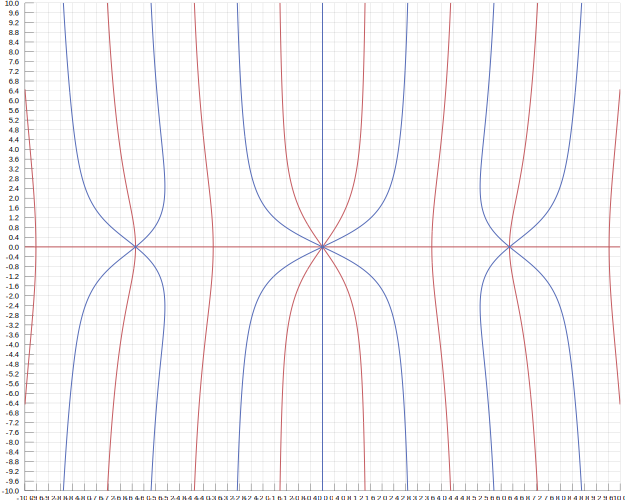

In [87]:
plot_levelCurves(separatedDelta; width = 2500, height = 2000)

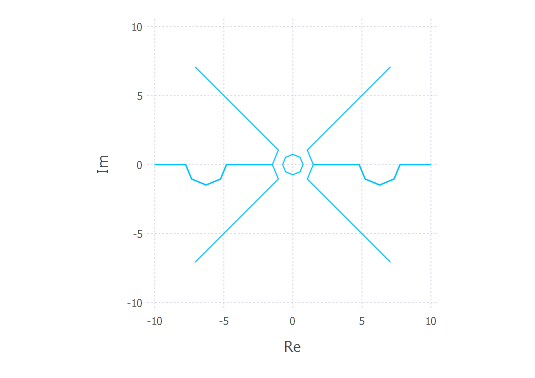

In [88]:
zeroList = [0, 2*pi, -2*pi]
(gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = get_gamma(a, n, zeroList)
gamma = collect(Iterators.flatten([gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus]))
plot_contour(gamma)

In [89]:
q = solve_IBVP(L, U, a, zeroList, f)

q (generic function with 1 method)

In [90]:
# q(1/2,1/2)

In [91]:
f(x) = sin(x*2*pi)
f(x) = x^2-1

f (generic function with 1 method)

In [92]:
(FPlusSym, FMinusSym) = get_FPlusMinusLambda2(adjointU; symbolic = true)
FPlusSymF = prettyPrint(simplify(FPlusSym(f)))

  / I*lambda    \ /              2  I*lambda                         I*lambda 
2*\e         - 1/*\0.125*I*lambda *e         + 0.25*lambda + 0.25*I*e         
------------------------------------------------------------------------------
                                            3                                 
                                   pi*lambda *(cos(lambda) - 1)               

        \  -I*lambda
- 0.25*I/*e         
--------------------
                    
                    

In [93]:
FMinusSymF = prettyPrint(simplify(FMinusSym(f)))

  / I*lambda    \ /              2  I*lambda                         I*lambda 
2*\e         - 1/*\0.125*I*lambda *e         + 0.25*lambda + 0.25*I*e         
------------------------------------------------------------------------------
                                             3                                
                                    pi*lambda *(cos(lambda) - 1)              

        \  -2*I*lambda
- 0.25*I/*e           
----------------------
                      
                      

In [94]:
sym = free_symbols(FPlusSymF)[1]

for lambda = 1:20
    tic()
    subs(FPlusSymF, sym, lambda)
    toc()
end

elapsed time: 0.004852171 seconds
elapsed time: 0.005936828 seconds
elapsed time: 0.005582129 seconds
elapsed time: 0.005920378 seconds
elapsed time: 0.00614245 seconds
elapsed time: 0.006674497 seconds
elapsed time: 0.006404104 seconds
elapsed time: 0.006278675 seconds
elapsed time: 0.006306433 seconds
elapsed time: 0.005111768 seconds
elapsed time: 0.006656505 seconds
elapsed time: 0.006053005 seconds
elapsed time: 0.008694222 seconds
elapsed time: 0.006002627 seconds
elapsed time: 0.006338305 seconds
elapsed time: 0.006663702 seconds
elapsed time: 0.005949679 seconds
elapsed time: 0.005645872 seconds
elapsed time: 0.006949517 seconds
elapsed time: 0.006879606 seconds


In [95]:
function FPlusSymFunc(lambda)
    result = 2 *(e^(im*lambda)-1) * (1/8*im*lambda^2*e^(im*lambda) + 1/4*lambda + 1/4*im*e^(im*lambda) - 0.25*im) * e^(-im*lambda)/(pi*lambda^3*(cos(lambda)-1))
    return result
end

function FMinusSymFunc(lambda)
    result = 2 *(e^(im*lambda)-1) * (1/8*im*lambda^2*e^(im*lambda) + 1/4*lambda + 1/4*im*e^(im*lambda) - 0.25*im) * e^(-2im*lambda)/(pi*lambda^3*(cos(lambda)-1))
    return result
end

FMinusSymFunc (generic function with 1 method)

In [152]:
q2 = solve_IBVP2(L, U, a, zeroList, f; FPlusFunc = FPlusSymFunc, FMinusFunc = FMinusSymFunc)
# q2 = solve_IBVP2(L, U, a, zeroList, f)

(::q) (generic function with 1 method)

In [153]:
q2(1/2, 1/2)

integrandPlus = 0.036364601873478286 + 0.016785423969653726im
integrandMinus = 0.09180269866355734 - 0.05852611389830493im
int_0_+ = 0.6666666666666666 - 1.1102230246251565e-16im
int_a_+ = -2.3906224173998562e-6 - 9.75781955236954e-18im
int_0_- = 0
int_a_- = -7.35811188150648e-5 + 9.961107459710572e-19im


0.6665906949254342 - 1.1978401126891414e-16im

integrandPlus = 0.04021581113428522 + 0.04418999915296904im
integrandMinus = 0.16014294630469877 - 0.027086264265339326im
int_0_+ = 0.6666666666666667 - 1.1796119636642288e-16im
int_a_+ = -0.0027952992857156102 + 2.0816681711721685e-17im
int_0_- = 0
int_a_- = -3.301755938178548e-5 + 1.853308088592409e-18im
integrandPlus = 0.03994508391088682 + 0.04417681648545307im
integrandMinus = 0.15971517742808153 - 0.02648637622340836im
int_0_+ = 0.6666666666666669 - 1.0408340855860843e-16im
int_a_+ = -0.002872133588756695 - 1.0408340855860843e-17im
int_0_- = 0
int_a_- = -3.375631210985923e-5 + 1.3029060794665648e-17im
integrandPlus = 0.03967526870886125 + 0.044162809156968914im
integrandMinus = 0.1592868617391019 - 0.025889785472953036im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = -0.0029493225176859296 - 6.938893903907228e-18im
int_0_- = 0
int_a_- = -3.449134091393995e-5 + 8.566891228529994e-18im
integrandPlus = 0.03940636523903921 + 0.04414798273780559im
integrandMinus = 0

int_0_+ = 0.6666666666666667 - 8.673617379884035e-17im
int_a_+ = -0.005426544023650804 + 1.3877787807814457e-17im
int_0_- = 0
int_a_- = -4.715358757201691e-5 + 7.640237184233789e-18im
integrandPlus = 0.03056569648171228 + 0.0431549267996723im
integrandMinus = 0.14360230317504544 - 0.006533227985555992im
int_0_+ = 0.6666666666666669 - 1.1102230246251565e-16im
int_a_+ = -0.005478491065031021 + 0.0im
int_0_- = 0
int_a_- = -4.6738028231108815e-5 - 1.81603863891322e-18im
integrandPlus = 0.03032928839689324 + 0.043114164775771624im
integrandMinus = 0.1431618548226393 - 0.006052345640294966im
int_0_+ = 0.6666666666666667 - 1.0061396160665481e-16im
int_a_+ = -0.005528766062999999 - 2.0816681711721685e-17im
int_0_- = 0
int_a_- = -4.625133430301226e-5 - 1.123504501238104e-17im
integrandPlus = 0.03009377039552647 + 0.043072776607387946im
integrandMinus = 0.14272128151551178 - 0.005574418846732214im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = -0.005577326341211041 + 0.0im
int_

int_a_+ = -0.005889062324374547 - 1.6696713456276768e-17im
int_0_- = 0
int_a_- = 5.377869183453374e-5 + 1.9569849213363355e-17im
integrandPlus = 0.02179408844247705 + 0.041082426999210615im
integrandMinus = 0.1259789522282401 + 0.010486688142634185im
int_0_+ = 0.6666666666666666 - 1.0408340855860843e-16im
int_a_+ = -0.005853001673263709 - 1.1492543028346347e-17im
int_0_- = 0
int_a_- = 5.932503836607615e-5 - 3.5236570605778894e-18im
integrandPlus = 0.021592499397670613 + 0.04102023216031705im
integrandMinus = 0.12554061792620103 + 0.010856448727132508im
int_0_+ = 0.6666666666666667 - 1.3183898417423734e-16im
int_a_+ = -0.005814544187147199 - 6.288372600415926e-18im
int_0_- = 0
int_a_- = 6.505650201302747e-5 + 8.40256683676266e-18im
integrandPlus = 0.02139175720774742 + 0.04095759154652374im
integrandMinus = 0.1251025077492231 + 0.01122361754674233im
int_0_+ = 0.6666666666666667 - 1.1796119636642288e-16im
int_a_+ = -0.005773698862594568 + 4.336808689942018e-19im
int_0_- = 0
int_a_- = 7.0

integrandMinus = 0.11167147792688135 + 0.021369452014284505im
int_0_+ = 0.6666666666666667 - 1.0408340855860843e-16im
int_a_+ = -0.003427818584229505 - 3.469446951953614e-18im
int_0_- = 0
int_a_- = 0.0003503442898090785 - 1.734723475976807e-18im
integrandPlus = 0.015407008410754694 + 0.03874172035290818im
integrandMinus = 0.11124425876873717 + 0.021658427756283512im
int_0_+ = 0.6666666666666666 - 1.249000902703301e-16im
int_a_+ = -0.0033223277222598734 + 3.469446951953614e-18im
int_0_- = 0
int_a_- = 0.0003622045962879128 - 1.474514954580286e-17im
integrandPlus = 0.015233436241282804 + 0.038666590951238665im
integrandMinus = 0.11081748674116443 + 0.021945106878890622im
int_0_+ = 0.6666666666666667 - 1.1102230246251565e-16im
int_a_+ = -0.003215376995970586 + 1.734723475976807e-18im
int_0_- = 0
int_a_- = 0.0003741994968967273 - 8.673617379884035e-19im
integrandPlus = 0.015060662336401348 + 0.03859114705652004im
integrandMinus = 0.11039116776261941 + 0.022229498192730852im
int_0_+ = 0.6666

integrandMinus = 0.09702117199324668 + 0.030174252464609978im
int_0_+ = 0.6666666666666667 - 8.326672684688674e-17im
int_a_+ = 0.0008185768377284332 - 1.0408340855860843e-17im
int_0_- = 0
int_a_- = 0.0007708895653693315 + 1.5612511283791264e-17im
integrandPlus = 0.009796443089624265 + 0.03594756270082047im
integrandMinus = 0.09661282420337665 + 0.03038802159684264im
int_0_+ = 0.6666666666666667 - 1.0408340855860843e-16im
int_a_+ = 0.0009459076952411903 - 5.204170427930421e-18im
int_0_- = 0
int_a_- = 0.0007795931539831286 + 1.214306433183765e-17im
integrandPlus = 0.00964984517268298 + 0.03586344242152872im
integrandMinus = 0.09620510376556377 + 0.03059979617282786im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0010729171120428174 - 3.469446951953614e-18im
int_0_- = 0
int_a_- = 0.000787833457508387 + 1.5612511283791264e-17im
integrandPlus = 0.009503987650010325 + 0.035779122921566375im
integrandMinus = 0.09579801505187215 + 0.030809584609876546im
int_0_+ = 0.666666

int_a_+ = 0.004920974631241095 - 4.336808689942018e-18im
int_0_- = 0
int_a_- = 0.000503696527402675 + 1.214306433183765e-17im
integrandPlus = 0.0048516557756821035 + 0.03272483721060165im
integrandMinus = 0.08197892685203881 + 0.03696530960586628im
int_0_+ = 0.6666666666666667 - 1.1102230246251565e-16im
int_a_+ = 0.0050035273718697934 + 1.2576745200831851e-17im
int_0_- = 0
int_a_- = 0.00046973763353209963 + 1.3877787807814457e-17im
integrandPlus = 0.004731265578477561 + 0.03263523515446861im
integrandMinus = 0.08159715876214123 + 0.03710908676311999im
int_0_+ = 0.6666666666666667 - 1.5265566588595902e-16im
int_a_+ = 0.005084055429476355 - 6.938893903907228e-18im
int_0_- = 0
int_a_- = 0.0004337510540779743 + 3.122502256758253e-17im
integrandPlus = 0.004611549129931584 + 0.03254553542101091im
integrandMinus = 0.08121615678007048 + 0.037251179359722504im
int_0_+ = 0.6666666666666667 - 1.1102230246251565e-16im
int_a_+ = 0.005162525078976594 - 3.469446951953614e-18im
int_0_- = 0
int_a_- = 0

integrandMinus = 0.06663422402149725 + 0.04164201756000928im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0063432110217650816 + 9.974659986866641e-18im
int_0_- = 0
int_a_- = -0.003356649507566409 + 1.3877787807814457e-17im
integrandPlus = 0.0002602234425905965 + 0.028812572512911902im
integrandMinus = 0.06628677866778969 + 0.04172162717584324im
int_0_+ = 0.6666666666666666 - 1.5265566588595902e-16im
int_a_+ = 0.006320161360927014 + 6.071532165918825e-18im
int_0_- = 0
int_a_- = -0.0035153626006144308 + 3.469446951953614e-18im
integrandPlus = 0.0001671139689012821 + 0.02872083569281578im
integrandMinus = 0.06594019464755758 + 0.0417998683110306im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0062945307150425 + 6.5052130349130266e-18im
int_0_- = 0
int_a_- = -0.003677350974192889 + 1.3877787807814457e-17im
integrandPlus = 7.459743192781733e-5 + 0.028629095421660374im
integrandMinus = 0.06559447357608812 + 0.04187674812073615im
int_0_+ = 0.666666

int_a_+ = -0.00341673533344637 + 1.3877787807814457e-17im
int_0_- = 0
int_a_- = -3.87641771763419e-5 - 5.800481622797449e-18im
integrandPlus = 0.03781207248664571 + 0.04404213288393524im
integrandMinus = 0.15627436722749918 - 0.021805230253912896im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = -0.0034948125088149857 - 3.122502256758253e-17im
int_0_- = 0
int_a_- = -3.944269036826321e-5 - 2.710505431213761e-18im
integrandPlus = 0.03754954163945801 + 0.044021727217857784im
integrandMinus = 0.15584211475500293 - 0.02123469861065848im
int_0_+ = 0.6666666666666669 - 1.1796119636642288e-16im
int_a_+ = -0.003572783819580209 - 1.734723475976807e-17im
int_0_- = 0
int_a_- = -4.0108269483500825e-5 + 1.5185606678375096e-17im
integrandPlus = 0.03728791961193695 + 0.044000546346376554im
integrandMinus = 0.15540942389026458 - 0.02066738430035232im
int_0_+ = 0.6666666666666667 - 1.1449174941446927e-16im
int_a_+ = -0.003650590307419619 + 0.0im
int_0_- = 0
int_a_- = -4.0759567417434226

integrandMinus = 0.14183979944319258 - 0.004627395530152233im
int_0_+ = 0.6666666666666669 - 1.0061396160665481e-16im
int_a_+ = -0.005669137497234428 + 1.0408340855860843e-17im
int_0_- = 0
int_a_- = -4.433735130090987e-5 + 4.3164798992079145e-18im
integrandPlus = 0.02939254828367565 + 0.042944903765868764im
integrandMinus = 0.14139891022916595 - 0.004158280809122585im
int_0_+ = 0.6666666666666666 - 1.1449174941446927e-16im
int_a_+ = -0.00571230855385127 - 1.0408340855860843e-17im
int_0_- = 0
int_a_- = -4.353883689991826e-5 - 8.409343100340694e-18im
integrandPlus = 0.029160581943921977 + 0.04290105945836502im
integrandMinus = 0.14095793516312388 - 0.00369208524417005im
int_0_+ = 0.6666666666666667 - 1.2836953722228372e-16im
int_a_+ = -0.005753605290584684 + 3.469446951953614e-18im
int_0_- = 0
int_a_- = -4.265536335353455e-5 + 3.9302328752599536e-19im
integrandPlus = 0.028929501288139398 + 0.04285661313412992im
integrandMinus = 0.14051688386960942 - 0.0032287997314566375im
int_0_+ = 0.66

int_a_- = 4.841536675144421e-5 + 6.288372600415926e-18im
integrandPlus = 0.021996525626161355 + 0.04114417190143098im
integrandMinus = 0.12641750302168098 + 0.010114326743924063im
int_0_+ = 0.6666666666666669 - 1.0755285551056204e-16im
int_a_+ = -0.005889062324374547 - 1.6696713456276768e-17im
int_0_- = 0
int_a_- = 5.377869183453374e-5 + 1.9569849213363355e-17im
integrandPlus = 0.02179408844247705 + 0.041082426999210615im
integrandMinus = 0.1259789522282401 + 0.010486688142634185im
int_0_+ = 0.6666666666666666 - 1.0408340855860843e-16im
int_a_+ = -0.005853001673263709 - 1.1492543028346347e-17im
int_0_- = 0
int_a_- = 5.932503836607615e-5 - 3.5236570605778894e-18im
integrandPlus = 0.021592499397670613 + 0.04102023216031705im
integrandMinus = 0.12554061792620103 + 0.010856448727132508im
int_0_+ = 0.6666666666666667 - 1.3183898417423734e-16im
int_a_+ = -0.005814544187147199 - 6.288372600415926e-18im
int_0_- = 0
int_a_- = 6.505650201302747e-5 + 8.40256683676266e-18im
integrandPlus = 0.02139

int_a_- = 0.00039856400786367034 + 1.5612511283791264e-17im
integrandPlus = 0.014717503083910245 + 0.038439330039048765im
integrandMinus = 0.10953991239046303 + 0.022791452589724565im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = -0.0028862065906250563 + 5.204170427930421e-18im
int_0_- = 0
int_a_- = 0.0004109179245094484 - 2.6020852139652106e-18im
integrandPlus = 0.014547114602076527 + 0.03836296400076536im
integrandMinus = 0.10911498759833392 + 0.02306903324687906im
int_0_+ = 0.6666666666666669 - 1.457167719820518e-16im
int_a_+ = -0.002773860676280199 + 1.0408340855860843e-17im
int_0_- = 0
int_a_- = 0.00042337502381711856 - 3.469446951953614e-18im
integrandPlus = 0.014377518116531344 + 0.03828629763843604im
integrandMinus = 0.10869053905855992 + 0.023344361243029313im
int_0_+ = 0.6666666666666669 - 1.249000902703301e-16im
int_a_+ = -0.0026602802616809912 + 1.3877787807814457e-17im
int_0_- = 0
int_a_- = 0.0004359262474161515 + 6.938893903907228e-18im
integrandPlus = 

int_a_+ = 0.0009459076952411903 - 5.204170427930421e-18im
int_0_- = 0
int_a_- = 0.0007795931539831286 + 1.214306433183765e-17im
integrandPlus = 0.00964984517268298 + 0.03586344242152872im
integrandMinus = 0.09620510376556377 + 0.03059979617282786im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0010729171120428174 - 3.469446951953614e-18im
int_0_- = 0
int_a_- = 0.000787833457508387 + 1.5612511283791264e-17im
integrandPlus = 0.009503987650010325 + 0.035779122921566375im
integrandMinus = 0.09579801505187215 + 0.030809584609876546im
int_0_+ = 0.6666666666666666 - 1.3183898417423734e-16im
int_a_+ = 0.0011995516980176871 + 6.071532165918825e-18im
int_0_- = 0
int_a_- = 0.0007955808170235119 + 1.5612511283791264e-17im
integrandPlus = 0.009358868780849882 + 0.035694607212139975im
integrandMinus = 0.09539156239336259 + 0.03101739531225785im
int_0_+ = 0.6666666666666666 - 9.71445146547012e-17im
int_a_+ = 0.0013257582200370708 - 1.3010426069826053e-17im
int_0_- = 0
int_a_- = 

int_a_+ = 0.004289422185870713 + 1.734723475976807e-18im
int_0_- = 0
int_a_- = 0.0006889090693384982 + 0.0im
integrandPlus = 0.005713407235918507 + 0.03334910609943715im
integrandMinus = 0.08467250074290082 + 0.035911037780971176im
int_0_+ = 0.6666666666666666 - 1.1796119636642288e-16im
int_a_+ = 0.004385133790664691 + 0.0im
int_0_- = 0
int_a_- = 0.000667721895197107 + 0.0im
integrandPlus = 0.005588249122718721 + 0.033260258160578544im
integrandMinus = 0.08428545497780983 + 0.03606682842355639im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = 0.004479079786796272 + 4.336808689942018e-18im
int_0_- = 0
int_a_- = 0.0006448608655407473 + 0.0im
integrandPlus = 0.005463777661639706 + 0.033171294852094926im
integrandMinus = 0.08389915380320566 + 0.036220879006113586im
int_0_+ = 0.6666666666666667 - 7.632783294297951e-17im
int_a_+ = 0.004571220803784662 - 6.071532165918825e-18im
int_0_- = 0
int_a_- = 0.0006202762619366003 + 2.6020852139652106e-17im
integrandPlus = 0.0053399910

int_0_- = 0
int_a_- = -0.0043574108855071285 + 2.0816681711721685e-17im
integrandPlus = -0.0002895772282276044 + 0.028262137843476448im
integrandMinus = 0.06422025010301757 + 0.04217079658381427im
int_0_+ = 0.6666666666666667 - 1.6653345369377348e-16im
int_a_+ = 0.006128061719198628 - 1.5178830414797062e-18im
int_0_- = 0
int_a_- = -0.004535247566363899 + 4.163336342344337e-17im
integrandPlus = -0.00037915749105532637 + 0.028170408723440794im
integrandMinus = 0.06387886702616462 + 0.042240976468909945im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = 0.006087199263993728 + 1.3010426069826053e-17im
int_0_- = 0
int_a_- = -0.004716112657105722 + 4.163336342344337e-17im
integrandPlus = -0.0004681561806180873 + 0.028078687430045914im
integrandMinus = 0.06353835600474966 + 0.04230983758426301im
int_0_+ = 0.6666666666666667 - 1.249000902703301e-16im
int_a_+ = 0.006043850271782224 - 9.107298248878237e-18im
int_0_- = 0
int_a_- = -0.004899946362589943 + 1.0408340855860843e-17im
i

int_a_- = -4.8255661985170326e-5 - 9.025983085941824e-18im
integrandPlus = 0.031761117152585325 + 0.04334917328661755im
integrandMinus = 0.145802320998937 - 0.0089822911392539im
int_0_+ = 0.6666666666666669 - 1.1796119636642288e-16im
int_a_+ = -0.0052029256715483575 - 2.0816681711721685e-17im
int_0_- = 0
int_a_- = -4.815685983922192e-5 + 6.3188657865170805e-18im
integrandPlus = 0.03152024628982419 + 0.04331161556233274im
integrandMinus = 0.14536264756328016 - 0.008486494699844im
int_0_+ = 0.6666666666666667 - 1.3183898417423734e-16im
int_a_+ = -0.005261113217263458 - 6.938893903907228e-18im
int_0_- = 0
int_a_- = -4.79997531868915e-5 - 4.573977915173222e-19im
integrandPlus = 0.03128026958681061 + 0.043273407106436707im
integrandMinus = 0.1449227989202344 - 0.0079936992470342im
int_0_+ = 0.6666666666666667 - 1.3183898417423734e-16im
int_a_+ = -0.0053178098130310415 + 1.734723475976807e-17im
int_0_- = 0
int_a_- = -4.778186203559636e-5 + 1.5720931501039814e-18im
integrandPlus = 0.031041186

int_a_- = 0.00011051097547586444 - 1.6479873021779667e-17im
integrandPlus = 0.02001016404832857 + 0.04050697147704905im
integrandMinus = 0.12204264205013358 + 0.013721988999427205im
int_0_+ = 0.6666666666666666 - 1.249000902703301e-16im
int_a_+ = -0.00542194317006962 + 1.0842021724855044e-18im
int_0_- = 0
int_a_- = 0.00011778399129708933 + 2.6020852139652106e-18im
integrandPlus = 0.019816149387184692 + 0.040440912395575665im
integrandMinus = 0.12160659330378243 + 0.01406874888774851im
int_0_+ = 0.6666666666666667 - 1.1796119636642288e-16im
int_a_+ = -0.005362469875308352 - 6.505213034913027e-19im
int_0_- = 0
int_a_- = 0.00012525511013456933 + 6.071532165918825e-18im
integrandPlus = 0.019622969621030065 + 0.04037444421166407im
integrandMinus = 0.1211708350000174 + 0.014412998228330089im
int_0_+ = 0.6666666666666669 - 1.3183898417423734e-16im
int_a_+ = -0.005300745789169731 + 1.3010426069826053e-18im
int_0_- = 0
int_a_- = 0.0001329249783210626 + 1.474514954580286e-17im
integrandPlus = 0.

integrandPlus = 0.01024069655155535 + 0.036198697873112584im
integrandMinus = 0.09783973193484043 + 0.02974069679749223im
int_0_+ = 0.6666666666666667 - 9.71445146547012e-17im
int_a_+ = 0.0005631650056929574 + 6.071532165918825e-18im
int_0_- = 0
int_a_- = 0.0007522072739667134 + 1.734723475976807e-18im
integrandPlus = 0.010091867048711413 + 0.03611519347610385im
integrandMinus = 0.09743014272193222 + 0.029958480345867445im
int_0_+ = 0.6666666666666667 - 1.0408340855860843e-16im
int_a_+ = 0.0006909780632495983 - 1.214306433183765e-17im
int_0_- = 0
int_a_- = 0.0007617515710433842 + 1.0408340855860843e-17im
integrandPlus = 0.009943783137477704 + 0.036031480732949844im
integrandMinus = 0.09702117199324668 + 0.030174252464609978im
int_0_+ = 0.6666666666666667 - 8.326672684688674e-17im
int_a_+ = 0.0008185768377284332 - 1.0408340855860843e-17im
int_0_- = 0
int_a_- = 0.0007708895653693315 + 1.5612511283791264e-17im
integrandPlus = 0.009796443089624265 + 0.03594756270082047im
integrandMinus = 0

int_0_+ = 0.6666666666666666 - 1.5265566588595902e-16im
int_a_+ = 0.005770996711588981 - 2.6020852139652106e-18im
int_0_- = 0
int_a_- = -4.888148205244719e-5 - 6.938893903907228e-18im
integrandPlus = 0.0034510324847796345 + 0.03164370273400033im
integrandMinus = 0.07744890125137995 + 0.03858117704163938im
int_0_+ = 0.6666666666666666 - 1.3183898417423734e-16im
int_a_+ = 0.005827223723578583 + 1.0842021724855044e-17im
int_0_- = 0
int_a_- = -0.00011053295048381317 + 1.0408340855860843e-17im
integrandPlus = 0.0033386046430819733 + 0.03155308863817874im
integrandMinus = 0.07707651253043034 + 0.038705255086368504im
int_0_+ = 0.6666666666666667 - 1.0408340855860843e-16im
int_a_+ = 0.005881081097092434 - 2.168404344971009e-17im
int_0_- = 0
int_a_- = -0.00017481605165881736 + 2.7755575615628914e-17im
integrandPlus = 0.0032268282093632986 + 0.03146240561631684im
integrandMinus = 0.07670492287008912 + 0.03882774189835507im
int_0_+ = 0.6666666666666667 - 1.1796119636642288e-16im
int_a_+ = 0.00593

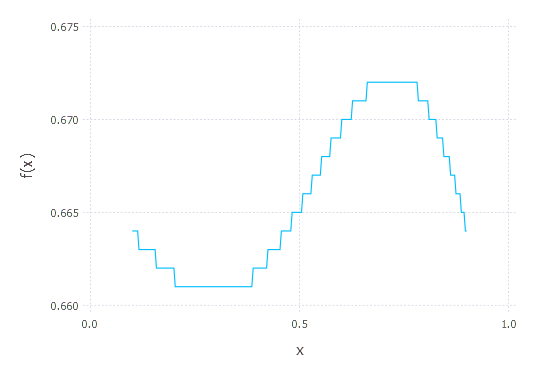

int_a_- = -0.002078225759540541 + 1.3877787807814457e-17im
integrandPlus = 0.0011252032942769725 + 0.029637727357251488im
integrandMinus = 0.06944459163005218 + 0.040955010858159016im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0064338038677478095 + 9.540979117872439e-18im
int_0_- = 0
int_a_- = -0.0022068689474465074 + 2.0816681711721685e-17im
integrandPlus = 0.001026672186968806 + 0.029546109578975365im
integrandMinus = 0.06909031718031602 + 0.04104582803166924im
int_0_+ = 0.6666666666666667 - 1.5265566588595902e-16im
int_a_+ = 0.006431646214793211 + 4.336808689942018e-19im
int_0_- = 0
int_a_- = -0.002338859823764205 + 3.122502256758253e-17im
integrandPlus = 0.0009287510539836407 + 0.029454470604178825im
integrandMinus = 0.06873689011219848 + 0.04113521884598562im
int_0_+ = 0.6666666666666667 - 1.3877787807814457e-16im
int_a_+ = 0.0064268633704356315 + 1.734723475976807e-18im
int_0_- = 0
int_a_- = -0.002474204972975746 + 2.7755575615628914e-17im
integrandPlus =

In [162]:
t = 0.1
q3(x) = prettyRound(q2(x,t))
Gadfly.plot([q3], 0.1, 0.9)

In [ ]:
for lambda = 1:20
    tic()
    FPlusSymFunc(lambda)
    toc()
end

In [138]:
(FPlus, FMinus) = get_FPlusMinusLambda2(adjointU; symbolic = false)
for lambda = 1:20
    tic()
    FPlus(lambda, f)
    toc()
end

elapsed time: 0.002710615 seconds
elapsed time: 0.001851114 seconds
elapsed time: 0.001821299 seconds
elapsed time: 0.00175036 seconds
elapsed time: 0.001689701 seconds
elapsed time: 0.00166811 seconds
elapsed time: 0.001689186 seconds
elapsed time: 0.001665026 seconds
elapsed time: 0.001699468 seconds
elapsed time: 0.001639323 seconds
elapsed time: 0.001693813 seconds
elapsed time: 0.001662455 seconds
elapsed time: 0.001628014 seconds
elapsed time: 0.001710777 seconds
elapsed time: 0.001847002 seconds
elapsed time: 0.001676335 seconds
elapsed time: 0.001543709 seconds
elapsed time: 0.001645492 seconds
elapsed time: 0.001562214 seconds
elapsed time: 0.001596656 seconds


In [165]:
lambda = symbols("lambda")
integrandPlusSym = prettyPrint(e^(im*lambda*x)*e^(-a*lambda^n*t) * FPlusSymF)

                                                                              
  / I*lambda    \ /              2  I*lambda                         I*lambda 
2*\e         - 1/*\0.125*I*lambda *e         + 0.25*lambda + 0.25*I*e         
------------------------------------------------------------------------------
                                                         3                    
                                                pi*lambda *(cos(lambda) - 1)  

                      2                       
        \  -0.1*lambda   -I*lambda  I*lambda*x
- 0.25*I/*e            *e         *e          
----------------------------------------------
                                              
                                              

In [169]:
N(subs(integrandPlusSym, lambda, 7.76415+0.0im))
# 20.0+0.0im

                                               7.76415*I*x
(2.06614968080718e-5 + 1.93768182297267e-5*I)*e           

**Case 1.2**

Now, for $b_0, b_1\in\hat{\mathbb{C}}$, consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) + b_0\varphi'(0) &= 0\\
\varphi(1) + b_1\varphi'(1) &= 0.
\end{align*}
We note that in complete form,
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + 0\cdot \varphi(1) + b_0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) &= 0\\
0\cdot \varphi(0) + 1\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + b_1\cdot \varphi^{(1)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&b_0\\ 0&0\end{bmatrix},\quad \beta = \begin{bmatrix}0&0\\ 1&b_1\end{bmatrix}.$$
Thus, $f(x)\in\Phi$ needs to satisfy 
\begin{align*}
Uf = \begin{bmatrix}
1&b_0&0&1\\
0&0&1&b_1
\end{bmatrix} \begin{bmatrix}f(0)\\f'(0)\\f(1)\\f'(1)\end{bmatrix} = 0.
\end{align*}

In [ ]:
# TBD

**Case 2.1**

Suppose $n=3$. Then 
$$S\phi(x) = (-i)^3 \phi^{(3)}(x) = i\phi^{(3)}.$$
Suppose $a=\pm i$.

For $\beta_0, \beta_1, \beta_2\in\hat{\mathbb{C}}$ ($\mathbb{C}$ including $0$ and $\infty$), consider the following boundary conditions $\Phi$:
\begin{align*}
\phi(0) + \beta_0\phi(1) &= 0\\
\phi^{(1)}(0) + \beta_1\phi^{(1)}(1) &= 0\\
\phi^{(2)}(0) + \beta_2\phi^{(2)}(1) &= 0.
\end{align*}

We note that in complete form,
* $S$ is given by
$$S\phi = p_0 \phi^{(3)} + p_1 \phi^{(2)} + p_2 \phi^{(1)} + p_3\phi$$
where $p_0=i$, $p_1=p_2=p_3=0$.
* $\Phi$ is given by 
\begin{align*}
1\cdot \phi(0) + \beta_0\cdot \phi(1) + 0\cdot \phi^{(1)}(0) + 0\cdot\phi^{(1)}(1) + 0\cdot \phi^{(2)}(0) + 0\cdot\phi^{(2)}(1) &= 0\\
0\cdot \phi(0) + 0\cdot \phi(1) + 1\cdot \phi^{(1)}(0) + \beta_1\cdot \phi^{(1)}(1) + 0\cdot \phi^{(2)}(0) + 0\cdot\phi^{(2)}(1) &= 0\\
0\cdot \phi(0) + 0\cdot \phi(1) + 0\cdot \phi^{(1)}(0) + 0\cdot \phi^{(1)}(1) + 1\cdot \phi^{(2)}(0) + \beta_2\cdot \phi^{(2)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0&0\\0&1&0\\ 0&0&1\end{bmatrix},\quad \beta = \begin{bmatrix}\beta_0&0&0\\0&\beta_1&0\\ 0&0&\beta_2\end{bmatrix}.$$
Thus, $f(x)\in\Phi$ needs to satisfy 
\begin{align*}
Uf = \begin{bmatrix}
1&0&0&\beta_0&0&0\\
0&1&0&0&\beta_1&0\\
0&0&1&0&0&\beta_2
\end{bmatrix} \begin{bmatrix}f(0)\\f'(0)\\f''(0)\\f(1)\\f'(1)\\f''(1)\end{bmatrix} = 0.
\end{align*}

In [ ]:
# TBD

**Case 2.2**

Now, for $b_0\in\hat{\mathbb{C}}$, consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) &= 0\\
\varphi(1) &= 1\\
\varphi^{(1)}(0) + b_0\varphi^{(1)}(1) &= 0.
\end{align*}
We note that in complete form,
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + 0\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0\\
0\cdot \varphi(0) + 1\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0\\
0\cdot \varphi(0) + 0\cdot \varphi(1) + 1\cdot \varphi^{(1)}(0) + b_0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0&0\\ 0&0&0\\ 0&1&0\end{bmatrix},\quad \beta = \begin{bmatrix}0&0&0\\ 1&0&0\\ 0&b_0&0\end{bmatrix}.$$
Thus, $f(x)\in\Phi$ needs to satisfy 
\begin{align*}
Uf = \begin{bmatrix}
1&0&0& 0&0&0\\
0&0&0& 1&0&0\\
0&1&0& 0&b_0&0
\end{bmatrix} \begin{bmatrix}f(0)\\f'(0)\\f''(0)\\f(1)\\f'(1)\\f''(1)\end{bmatrix} = 0.
\end{align*}

In [ ]:
# TBD